In [1]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, LeaveOneOut, cross_validate, cross_val_score
)
from sklearn.linear_model import (
    LinearRegression, Lasso, LassoCV, MultiTaskLasso, MultiTaskLassoCV,
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance


# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

# Specialized imputation and visualization packages
import miceforest as mf
import missingno as msno
#from missforest import MissForest
#import magic
from src.gain import *

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap
import shapiq
from tabpfn import TabPFNRegressor  

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


## Load data 

In [2]:
data = load_pickle_data_palettes()

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features, miss_mask = data["df_select_features"], data["miss_mask"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness, select_MRIvolume, select_PET = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

df_X = df_X[miss_mask]
df_y = df_y[miss_mask]
df_all = df_all[miss_mask]

## Test train split

In [3]:
if True: 

    idx_train = list(df_X.isna().any(axis=1))
    idx_test = list(~df_X.isna().any(axis=1))

    set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
    intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

    for i, bool_test in enumerate(idx_test): 
        if intersect_rid_idx.iloc[i] & bool_test:
            idx_test[i] = False
            idx_train[i] = True

    df_X_train = df_X.loc[idx_train]
    df_X_test = df_X.loc[idx_test]

    df_y_train = df_y.loc[idx_train]
    df_y_test = df_y.loc[idx_test]

    c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
    c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

    continuous_model = SimpleImputer(strategy="constant", fill_value=-1)
    name_continuous_imputer  = "KNNImputer"
    ordinal_model = SimpleImputer(strategy="constant", fill_value=-1)
    name_ordinal_imputer = "SimpleImputer_constant"

    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Separate imputers for ordinal and continuous data
    print("Using separate imputers for ordinal and continuous data.")

    df_X_train = df_X_train.copy()
    df_X_test = df_X_test.copy()

    # Continuous Imputation Transformer (Example: SimpleImputer)
    continuous_imputer = Pipeline([
        (name_continuous_imputer, continuous_model),
    ])

    # Ordinal Imputation Transformer (Example: KNN Imputer)
    ordinal_imputer = Pipeline([
        (name_ordinal_imputer, ordinal_model)
    ])

    # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_imputer, ordinal_features),
            ('continuous', continuous_imputer, continuous_features)
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

        # Separate imputers for ordinal and continuous data

    # Fit and transform, then convert back to DataFrame with original column names
    start = time.time()
    pipeline.fit(df_X_train)
    end = time.time()

    impute_model_time = end - start

    X_train_imputed = pipeline.transform(df_X_train)
    df_X_train_imputed = df_X_train.copy()
    df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

    # Transform the test set
    if df_X_test.isna().any().any(): 
        X_test_imputed = pipeline.transform(df_X_test)
        df_X_test_imputed = df_X_test.copy()
        df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
    else : 
        print("No NaN in test data -> Keep as it is. ")
        df_X_test_imputed = df_X_test
        
    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()

    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)


Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 


In [4]:
X_train_adjusted = X_train_adjusted.where(~df_X[idx_train].isna(), np.nan)

# RandomForest with missing values

In [5]:
if True: 

    rf_miss = RandomForestRegressor()
    name_model = "RandomForestRegressor"

    # Perform prediction and save variables
    start = time.time()
    rf_miss.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = rf_miss.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }

    def compute_all_metrics(y_test, y_pred): 
        # Metrics computed in adjusted space
        mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
        mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
        r2 = r2_score(y_test,y_pred, multioutput="raw_values")
        explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

        try: 
            corr_p = correlation(y_pred, y_test)
        except: 
            print("Problem when computing correlation!")
            if type(y_test) != type(y_pred): 
                print("Type of inputs is different.")
                corr_p = None
            else : 
                corr_p = pearsonr(y_test, y_pred)

        return mse_score, mae_score, r2, explained_variance, corr_p

    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted.values)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred.values)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }


KeyboardInterrupt: 

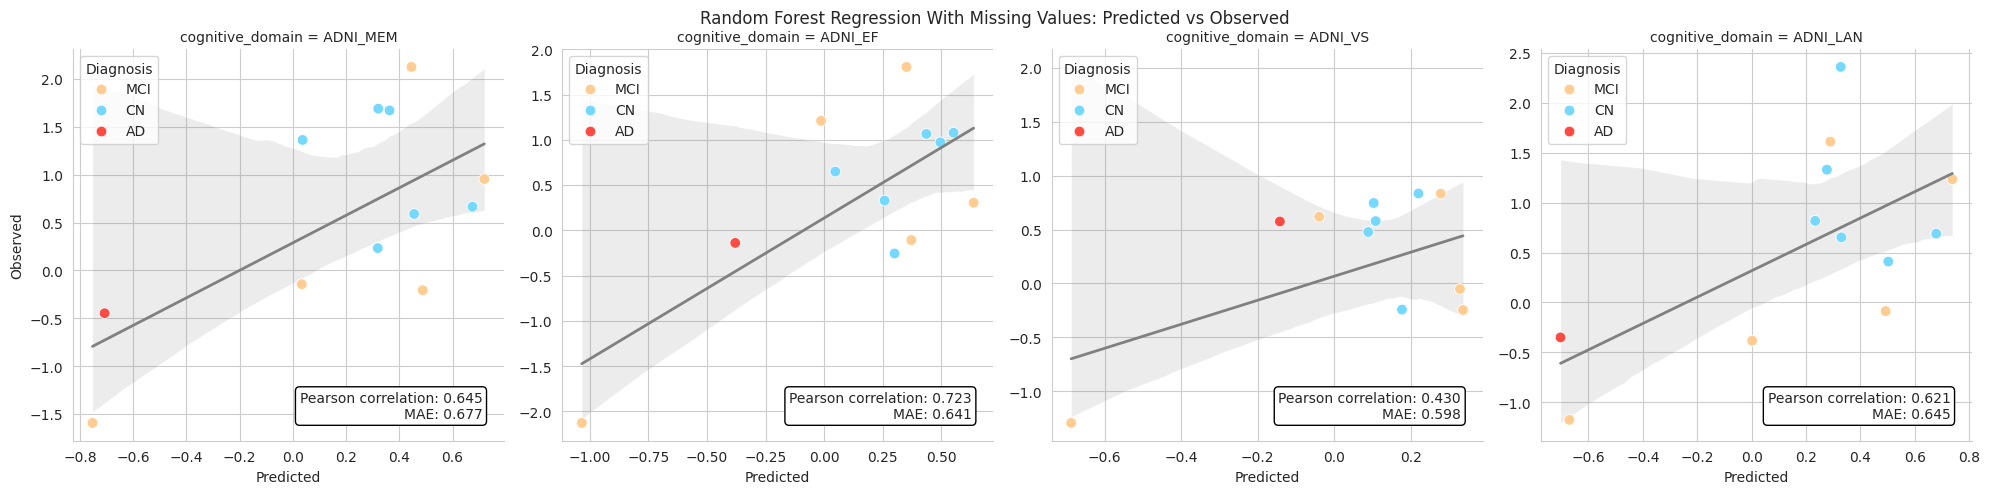

In [ ]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

sns.set_style("whitegrid")

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    ax.legend(loc="upper left", title="Diagnosis", fontsize=10)
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle("Random Forest Regression With Missing Values: Predicted vs Observed")  # Add a title

plt.show()


#### Model specific importance values

In [ ]:
n_features = 20

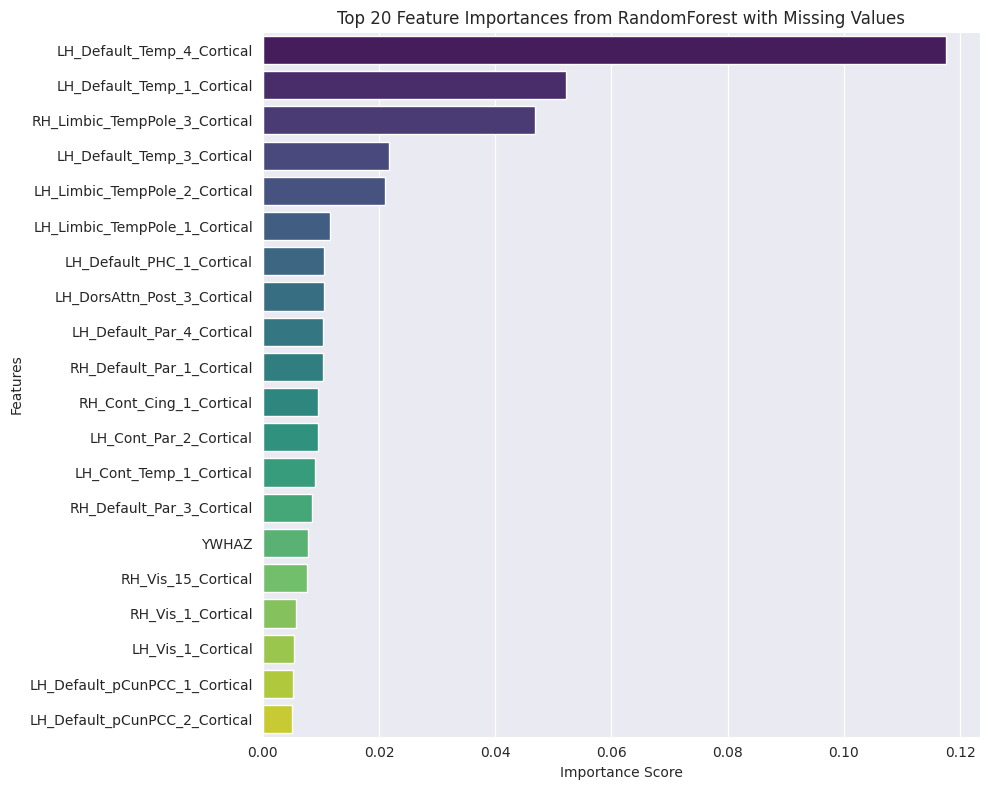

In [ ]:
sns.set_style("darkgrid")

# Extract feature importances
feature_importances = rf_miss.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top 20
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Plot the top 20 feature importances using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_df, x="Importance", y="Feature", palette="viridis")
plt.title(f"Top {n_features} Feature Importances from RandomForest with Missing Values")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

#### Permutation importance values

In [ ]:
X_test = X_test_adjusted
X_train = X_train_adjusted
Y_test = y_test_adjusted

model = rf_miss

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=pearson_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance (Pearson Correlation)", top_n=n_features)

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

NameError: name 'n_features' is not defined

#### Shapeley values

  0%|          | 0/12 [00:00<?, ?it/s]

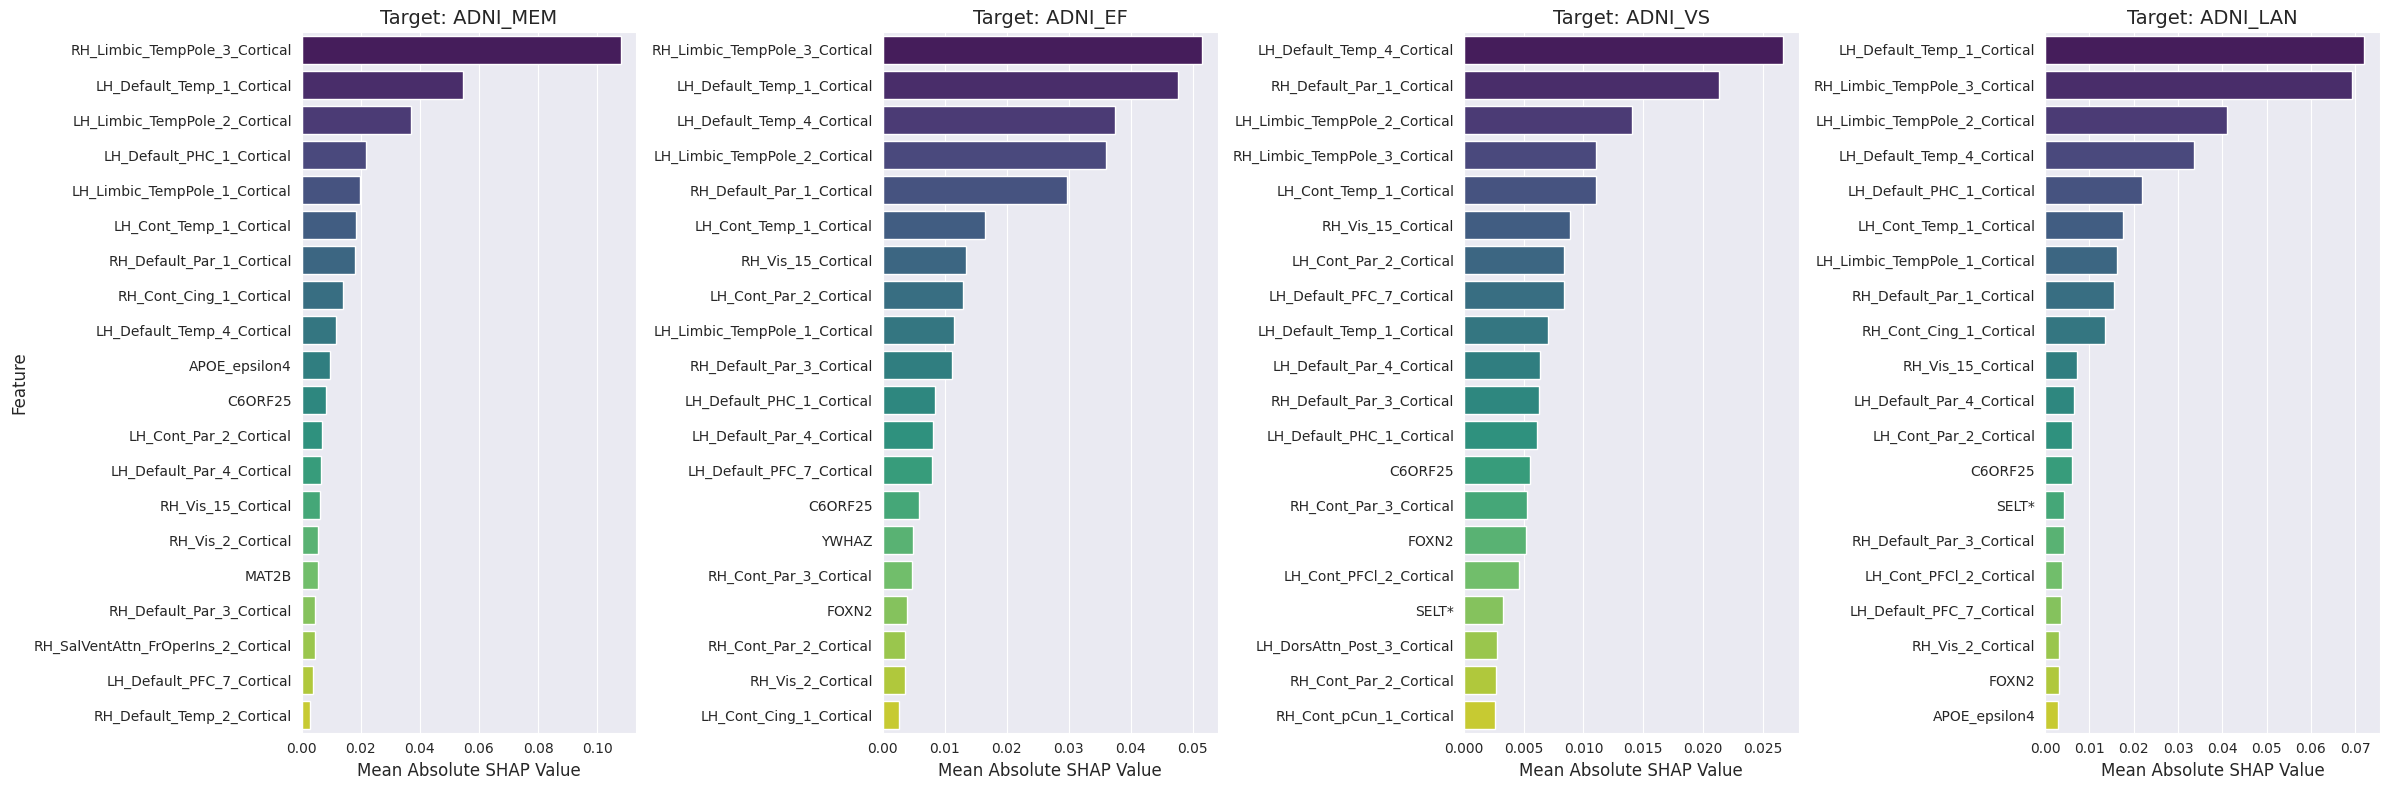

In [ ]:
# Step 1: Initialize the SHAP Explainer and Compute SHAP Values
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer(X_test)  # SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

# Step 3: Plot top features for each target as subplots
num_targets = len(Y_test.columns)
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

for i, (target, ax) in enumerate(zip(shap_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = shap_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h"
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


SHAP Summary for Target: ADNI_MEM


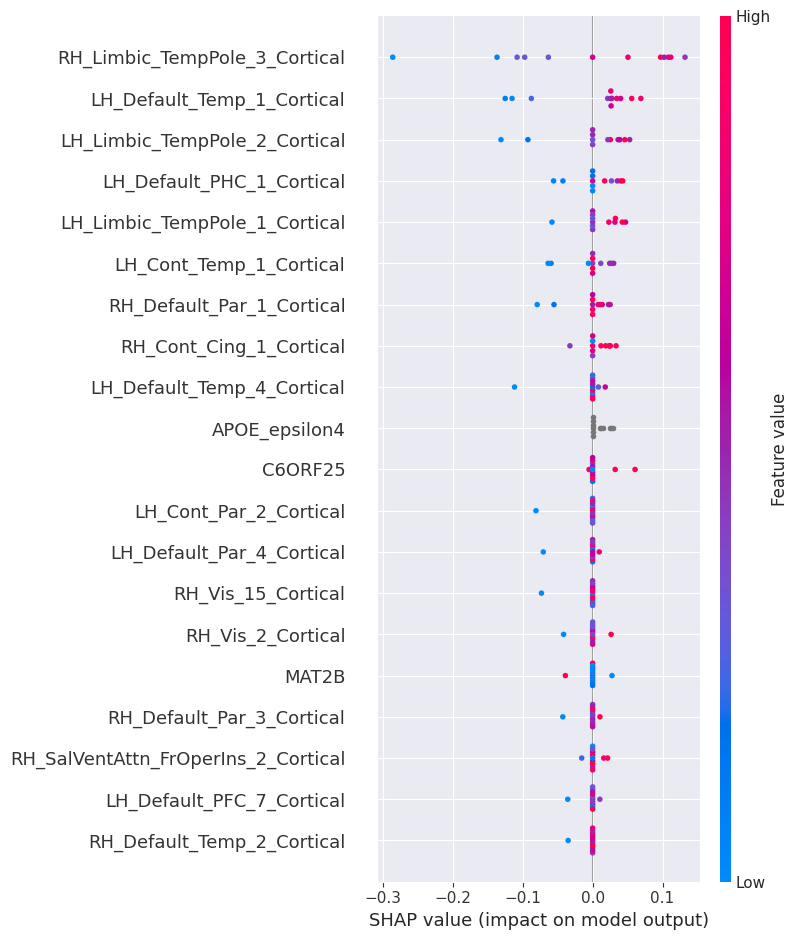

SHAP Summary for Target: ADNI_EF


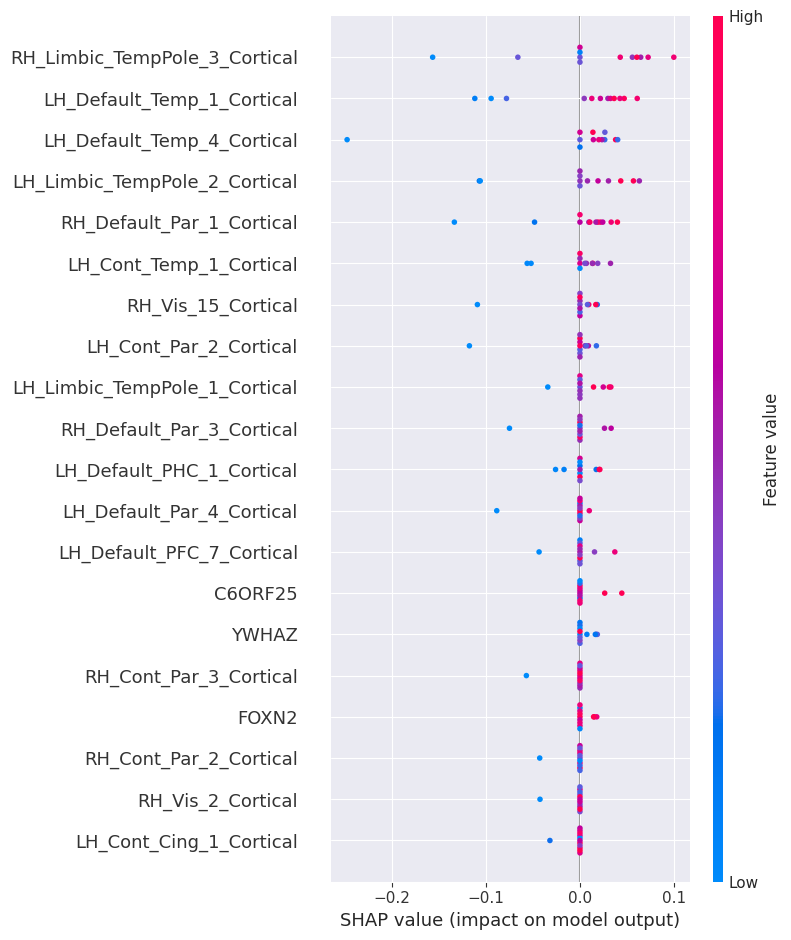

SHAP Summary for Target: ADNI_VS


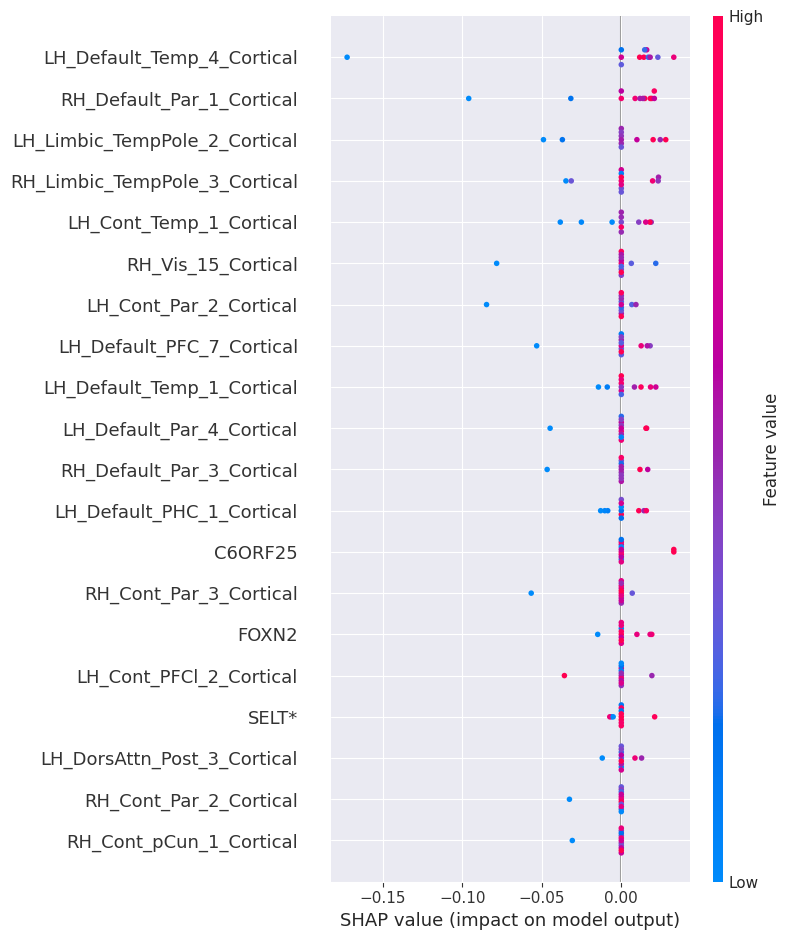

SHAP Summary for Target: ADNI_LAN


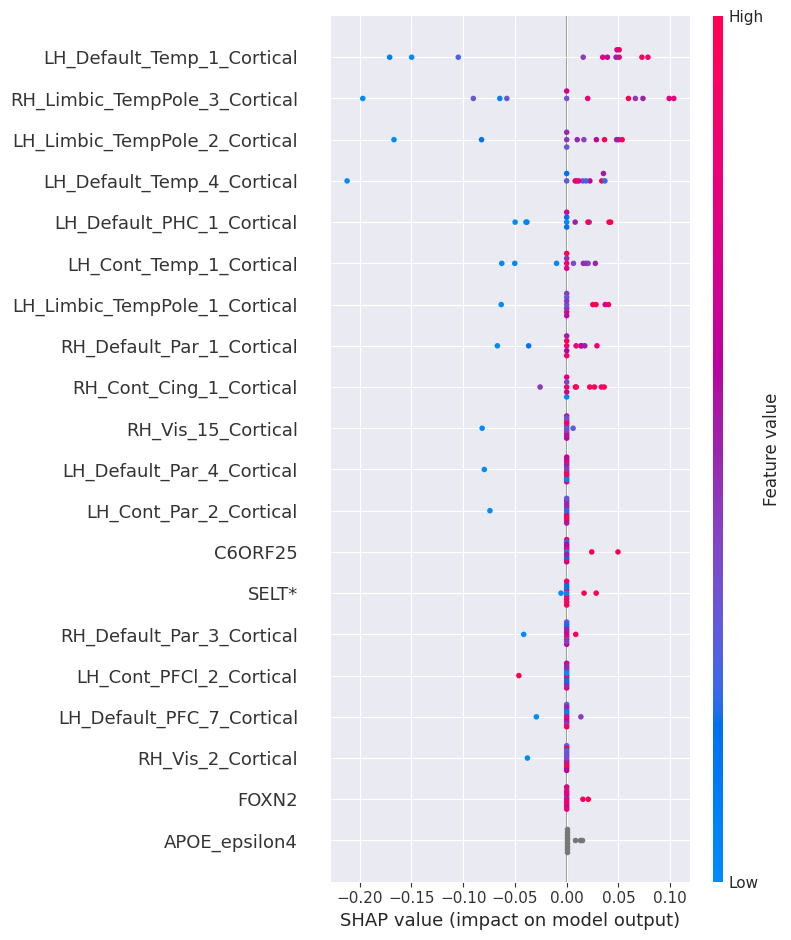

: 

In [ ]:
# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    print(f"SHAP Summary for Target: {target}")
    shap.summary_plot(shap_values.values[:, :, i], X_test, feature_names=X_test.columns, max_display=n_features)

### Shap-IQ values

In [ ]:
n_features = X_train.shape[1]

explainer_tabular = shapiq.TabularExplainer(model=model, data=X_train.values, index="SII", max_order=2)
# explain the model's prediction for the first sample
interaction_values = explainer_tabular.explain(X_test.values, budget=n_features, random_state=42)
# analyse interaction values
print(interaction_values)

ValueError: Maximum allowed dimension exceeded

In [ ]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=df_X.columns,
)

In [ ]:
_ = shapiq.stacked_bar_plot(
    interaction_values.get_n_order(1),
    feature_names=df_X.columns,
)

In [ ]:
interaction_values.plot_force(feature_names=df_X.columns)

# TabPFN with missing values

In [31]:
X_train_adjusted = X_train_adjusted.sample(frac=0.7, random_state=42)
y_train_adjusted = y_train_adjusted.loc[X_train_adjusted.index]

In [32]:
all(X_train_adjusted.index == y_train_adjusted.index)

True

In [33]:
X_train_adjusted.shape

(282, 261)

In [35]:
y_preds_ = []

if True: 

    for target in y_train_adjusted.columns:
        print(f"Target: {target}")
        y_train_adjusted[target] = y_train_adjusted[target].astype(float)

        tabpfn_miss = TabPFNRegressor()
        name_model = "TabPFNRegressor"

        # Perform prediction and save variables
        start = time.time()
        tabpfn_miss.fit(X_train_adjusted, y_train_adjusted[target]) 
        end = time.time()

        fit_time = end - start

        print(f"Fitting time: {fit_time:.2f} seconds")

        start = time.time()
        y_pred_adjusted = tabpfn_miss.predict(X_test_adjusted)
        end = time.time()

        pred_time = end - start

        y_preds_.append(y_pred_adjusted)

        print(f"Prediction time: {pred_time:.2f} seconds")

Target: ADNI_MEM
Fitting time: 2.58 seconds
Prediction time: 194.35 seconds
Target: ADNI_EF
Fitting time: 2.63 seconds
Prediction time: 166.36 seconds
Target: ADNI_VS
Fitting time: 2.32 seconds
Prediction time: 157.87 seconds
Target: ADNI_LAN
Fitting time: 2.33 seconds
Prediction time: 168.44 seconds


In [41]:
y_preds_

[array([ 0.34051782, -0.30010754, -0.8906426 ,  0.14429589,  0.79825914,
        -0.698489  ,  0.90671253,  0.7442266 ,  0.96622807,  0.40511745,
         0.9290054 ,  0.5248084 ], dtype=float32),
 array([ 0.7568322 , -0.68805224, -0.74654233, -0.5871762 ,  0.715114  ,
        -0.33555114,  0.73844326,  0.12870269,  0.9463488 ,  0.3449747 ,
         0.8053502 ,  0.5380834 ], dtype=float32),
 array([ 0.09428862, -0.48315066,  0.01721567, -0.32451242,  0.40160406,
        -0.14551759,  0.31131047,  0.501145  ,  0.1491169 ,  0.43215856,
         0.22475728,  0.07128631], dtype=float32),
 array([ 0.18389009, -0.887082  , -0.28475863,  0.01556603,  0.5273117 ,
        -1.0110059 ,  0.70595586,  0.98716784,  0.6807027 ,  0.310968  ,
         0.6160494 ,  0.5473871 ], dtype=float32)]

In [43]:
y_pred_adjusted_copy = pd.DataFrame(np.vstack(y_preds_).T, columns=y_train_adjusted.columns)

In [44]:
# Metrics computed in original space
y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted_copy, c_test)

params = {
    "ordinal_imputer": name_ordinal_imputer, 
    "continuous_imputer": name_continuous_imputer, 
    "model": name_model, "train_shape" : X_train_adjusted.shape, 
    "test_shape": X_test_adjusted.shape
}

In [45]:
# Metrics computed in original space
y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted_copy, c_test)

params = {
    "ordinal_imputer": name_ordinal_imputer, 
    "continuous_imputer": name_continuous_imputer, 
    "model": name_model, "train_shape" : X_train_adjusted.shape, 
    "test_shape": X_test_adjusted.shape
}

def compute_all_metrics(y_test, y_pred): 
    # Metrics computed in adjusted space
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    r2 = r2_score(y_test,y_pred, multioutput="raw_values")
    explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

    try: 
        corr_p = correlation(y_pred, y_test)
    except: 
        print("Problem when computing correlation!")
        if type(y_test) != type(y_pred): 
            print("Type of inputs is different.")
            corr_p = None
        else : 
            corr_p = pearsonr(y_test, y_pred)

    return mse_score, mae_score, r2, explained_variance, corr_p


In [46]:
if df_X_test.shape[0] != 1: 

    # Metrics computed in adjusted space
    mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted_copy.values)

    results_adj = {
        "mse_score": mse_score_adj, 
        "mae_score":mae_score_ajd, 
        "r2":r2_adj, 
        "explained_variance":explained_variance_adj, 
        "corr":corr_adj, 
    }

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred.values)

    results_org = {
        "mse_score": mse_score, 
        "mae_score": mae_score, 
        "r2": r2, 
        "explained_variance": explained_variance, 
        "corr": corr, 
    }

else : 
    print("Saving predictions in dict!")
    results_adj = {
        "y_pred": y_pred_adjusted_copy.values, 
        "y_test": y_pred_adjusted_copy.values,
    }

    results_org = {
        "y_pred": y_pred.values, 
        "y_test": df_y_test.values,
    }


dict_results = {
    "params": params, 
    "results_adj": results_adj, 
    "results_org": results_org
    }

Problem when computing correlation!
Problem when computing correlation!


In [47]:
pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted_copy.reset_index(drop=True)],axis=1)

DX   RID  ADNI_MEM   ADNI_EF   ADNI_VS  ADNI_LAN
0   MCI  2002  0.340518  0.756832  0.094289  0.183890
1   MCI  2374 -0.300108 -0.688052 -0.483151 -0.887082
2   MCI  4167 -0.890643 -0.746542  0.017216 -0.284759
3    CN  4176  0.144296 -0.587176 -0.324512  0.015566
4    CN  4179  0.798259  0.715114  0.401604  0.527312
5    AD  4215 -0.698489 -0.335551 -0.145518 -1.011006
6    CN  4292  0.906713  0.738443  0.311310  0.705956
7   MCI  4300  0.744227  0.128703  0.501145  0.987168
8    CN  4349  0.966228  0.946349  0.149117  0.680703
9    CN  4453  0.405117  0.344975  0.432159  0.310968
10  MCI  4489  0.929005  0.805350  0.224757  0.616049
11   CN  4505  0.524808  0.538083  0.071286  0.547387

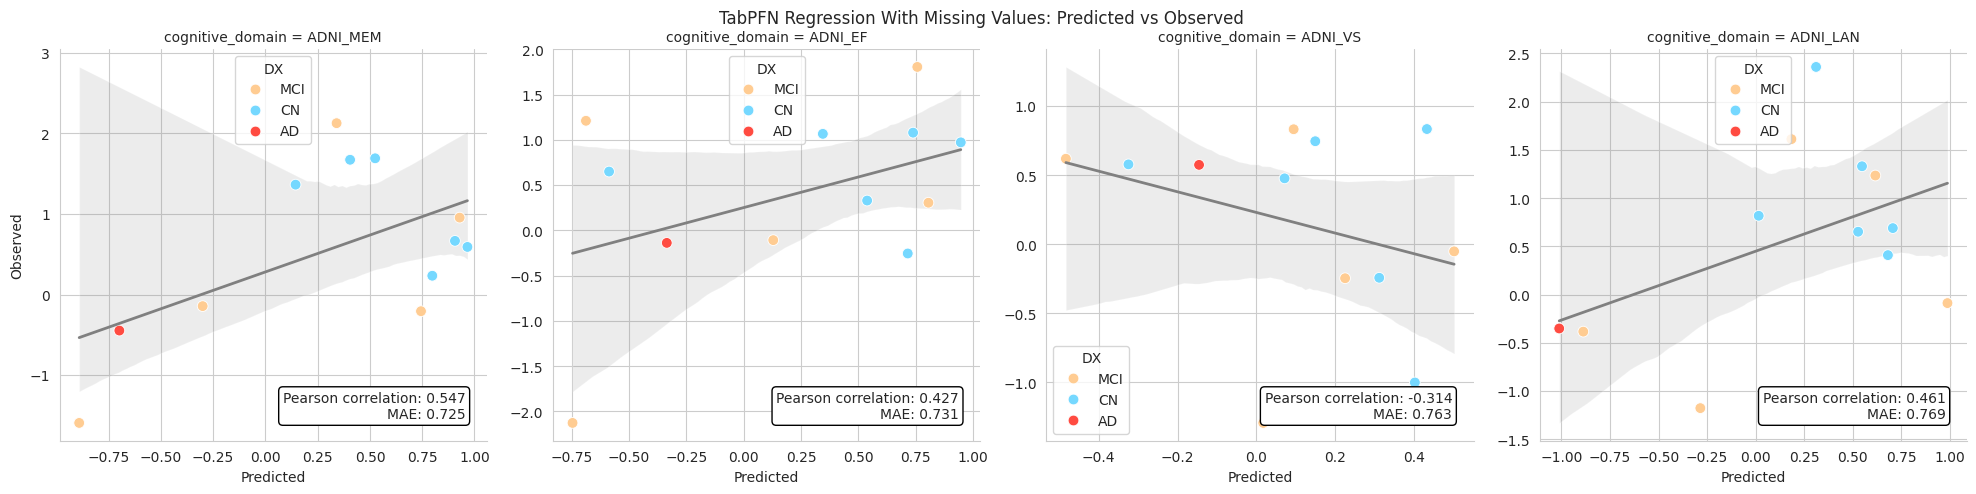

In [49]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted_copy.reset_index(drop=True)],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

sns.set_style("whitegrid")

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle("TabPFN Regression With Missing Values: Predicted vs Observed")  # Add a title

plt.show()

### TabPFN with feature importance computation 

In [ ]:
import time
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

# Pearson correlation as scorer
def pearson_score(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

pearson_scorer = make_scorer(pearson_score, greater_is_better=True)

# Shuffle and align train sets
X_train_adjusted = X_train_adjusted.sample(frac=0.7, random_state=42)
y_train_adjusted = y_train_adjusted.loc[X_train_adjusted.index]
assert all(X_train_adjusted.index == y_train_adjusted.index)

# Output containers
y_preds_ = []
permutation_importances = {}
shap_values_dict = {}

# Loop over targets
for target in y_train_adjusted.columns:
    print(f"\nTarget: {target}")
    y_train_adjusted[target] = y_train_adjusted[target].astype(float)

    tabpfn_miss = TabPFNRegressor()

    start = time.time()
    tabpfn_miss.fit(X_train_adjusted, y_train_adjusted[target])
    fit_time = time.time() - start
    print(f"Fitting time: {fit_time:.2f} seconds")

    start = time.time()
    y_pred_adjusted = tabpfn_miss.predict(X_test_adjusted)
    pred_time = time.time() - start
    print(f"Prediction time: {pred_time:.2f} seconds")

    y_preds_.append(y_pred_adjusted)

    # ----- Permutation Importance -----
    print("Computing permutation importances...")
    result = permutation_importance(
        tabpfn_miss,
        X_test_adjusted,
        y_test_adjusted[target],  # <- Assuming you have this
        scoring=pearson_scorer,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    permutation_importances[target] = result

    # ----- SHAP Values -----
    print("Computing SHAP values (may be slow)...")
    # Use training data as the background (summary) dataset
    X_background = X_train_adjusted.sample(n=min(100, len(X_train_adjusted)), random_state=42)

    explainer = shap.Explainer(tabpfn_miss.predict, X_background, algorithm="kernel")
    shap_values = explainer(X_test_adjusted)
    shap_values_dict[target] = shap_values



Target: ADNI_MEM
Fitting time: 1.82 seconds
Prediction time: 62.08 seconds
Computing permutation importances...


KeyboardInterrupt: 

### TabPFN with AutoTAbPFNRegressor

AutoTabPFNRegressor yields the most accurate predictions for TabPFN and is recommended for most use cases. The AutoTabPFNClassifier and AutoTabPFNRegressor automatically run a hyperparameter search and build an ensemble of strong hyperparameters. You can control the runtime using ´max_time´ and need to make no further adjustments to get best results.

In [13]:
X_train_adjusted = X_train_adjusted.sample(frac=0.4, random_state=42)
y_train_adjusted = y_train_adjusted.loc[X_train_adjusted.index]

X_train_adjusted.shape

(403, 261)

In [17]:
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNRegressor

y_preds_ = []

if True: 

    for target in y_train_adjusted.columns:
        print(f"Target: {target}")
        y_train_adjusted[target] = y_train_adjusted[target].astype(float)

        autotabpfn_miss = AutoTabPFNRegressor(max_time=30) # runs for 30 seconds
        name_model = "AutoTabPFNRegressor"

        # Perform prediction and save variables
        start = time.time()
        autotabpfn_miss.fit(X_train_adjusted, y_train_adjusted[target]) 
        end = time.time()

        fit_time = end - start

        print(f"Fitting time: {fit_time:.2f} seconds")

        start = time.time()
        y_pred_adjusted = autotabpfn_miss.predict(X_test_adjusted)
        end = time.time()

        pred_time = end - start

        y_preds_.append(y_pred_adjusted)

        print(f"Prediction time: {pred_time:.2f} seconds")

Target: ADNI_MEM


INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(0.6385472646745363)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Model losses: [0.63854726]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Best weights: [1.]


Fitting time: 225.62 seconds
Prediction time: 305.34 seconds
Target: ADNI_EF


INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(0.7276988235688399)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Model losses: [0.72769882]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Best weights: [1.]


Fitting time: 228.06 seconds
Prediction time: 306.75 seconds
Target: ADNI_VS


INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(0.5754173137813268)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Model losses: [0.57541731]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Best weights: [1.]


Fitting time: 236.85 seconds
Prediction time: 320.82 seconds
Target: ADNI_LAN


INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(0.9126877761904478)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Model losses: [0.91268778]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Best weights: [1.]


Fitting time: 224.70 seconds
Prediction time: 797.34 seconds


Problem when computing correlation!
Problem when computing correlation!


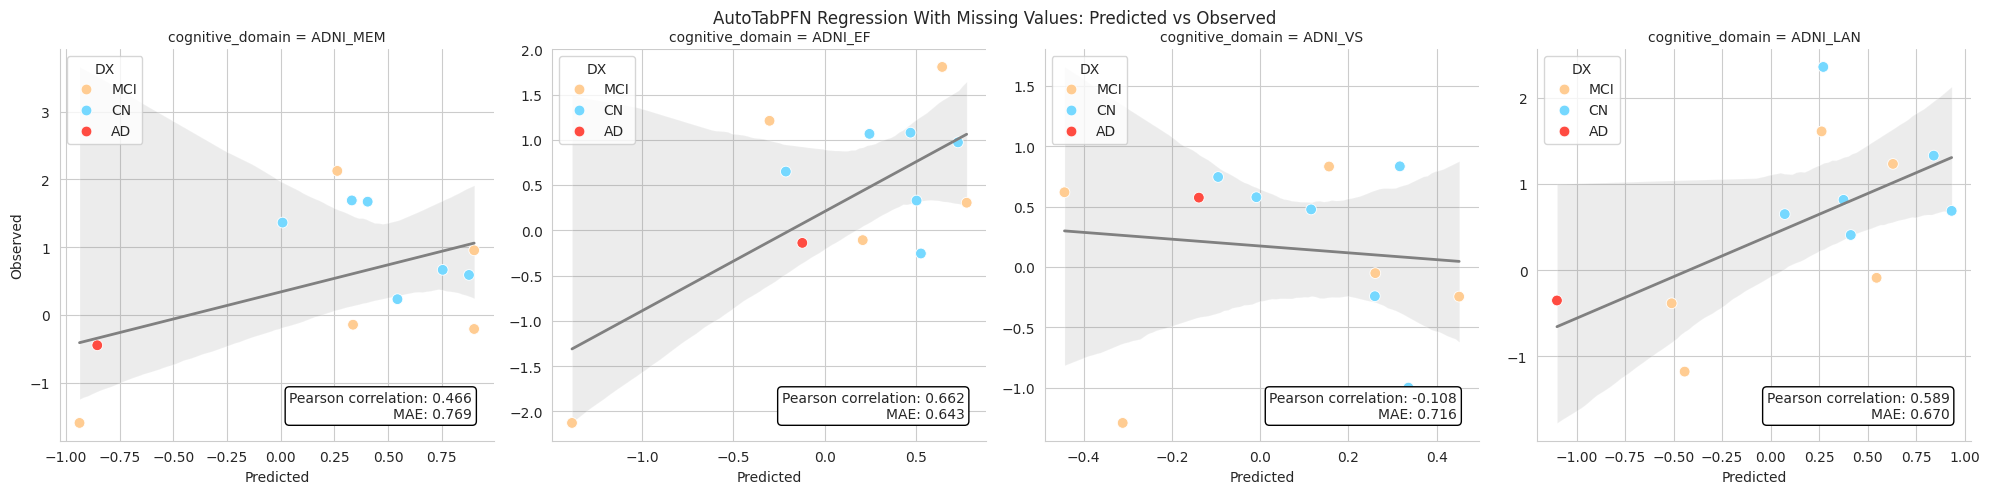

In [ ]:
y_pred_adjusted_copy = pd.DataFrame(np.vstack(y_preds_).T, columns=y_train_adjusted.columns)

# Metrics computed in original space
y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted_copy, c_test)

def compute_all_metrics(y_test, y_pred): 
    # Metrics computed in adjusted space
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    r2 = r2_score(y_test,y_pred, multioutput="raw_values")
    explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

    try: 
        corr_p = correlation(y_pred, y_test)
    except: 
        print("Problem when computing correlation!")
        if type(y_test) != type(y_pred): 
            print("Type of inputs is different.")
            corr_p = None
        else : 
            corr_p = pearsonr(y_test, y_pred)

    return mse_score, mae_score, r2, explained_variance, corr_p


if df_X_test.shape[0] != 1: 

    # Metrics computed in adjusted space
    mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted_copy.values)

    results_adj = {
        "mse_score": mse_score_adj, 
        "mae_score":mae_score_ajd, 
        "r2":r2_adj, 
        "explained_variance":explained_variance_adj, 
        "corr":corr_adj, 
    }

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred.values)

    results_org = {
        "mse_score": mse_score, 
        "mae_score": mae_score, 
        "r2": r2, 
        "explained_variance": explained_variance, 
        "corr": corr, 
    }

else : 
    print("Saving predictions in dict!")
    results_adj = {
        "y_pred": y_pred_adjusted_copy.values, 
        "y_test": y_pred_adjusted_copy.values,
    }

    results_org = {
        "y_pred": y_pred.values, 
        "y_test": df_y_test.values,
    }


pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted_copy.reset_index(drop=True)],axis=1)
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted_copy.reset_index(drop=True)],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

sns.set_style("whitegrid")

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    sns.move_legend(ax, "upper left")
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle("AutoTabPFN Regression With Missing Values: Predicted vs Observed")  # Add a title

plt.show()

# Feature importance for other models

## Train RandomForestRegressor

In [ ]:
if True: 

    idx_train = list(df_X.isna().any(axis=1))
    idx_test = list(~df_X.isna().any(axis=1))

    set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
    intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

    for i, bool_test in enumerate(idx_test): 
        if intersect_rid_idx.iloc[i] & bool_test:
            idx_test[i] = False
            idx_train[i] = True

    df_X_train = df_X.loc[idx_train]
    df_X_test = df_X.loc[idx_test]

    df_y_train = df_y.loc[idx_train]
    df_y_test = df_y.loc[idx_test]

    c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
    c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

    continuous_model  = imputer = KNNImputer(n_neighbors=1)
    name_continuous_imputer  = "KNNImputer"
    ordinal_model = SimpleImputer(strategy="constant", fill_value=-1)
    name_ordinal_imputer = "SimpleImputer_constant"
    rf_model = RandomForestRegressor()
    name_model = "RandomForestRegressor"

    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Separate imputers for ordinal and continuous data
    print("Using separate imputers for ordinal and continuous data.")

    df_X_train = df_X_train.copy()
    df_X_test = df_X_test.copy()

    # Continuous Imputation Transformer (Example: SimpleImputer)
    continuous_imputer = Pipeline([
        (name_continuous_imputer, continuous_model),
    ])

    # Ordinal Imputation Transformer (Example: KNN Imputer)
    ordinal_imputer = Pipeline([
        (name_ordinal_imputer, ordinal_model)
    ])

    # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_imputer, ordinal_features),
            ('continuous', continuous_imputer, continuous_features)
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

        # Separate imputers for ordinal and continuous data

    # Fit and transform, then convert back to DataFrame with original column names
    start = time.time()
    pipeline.fit(df_X_train)
    end = time.time()

    impute_model_time = end - start

    X_train_imputed = pipeline.transform(df_X_train)
    df_X_train_imputed = df_X_train.copy()
    df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

    # Transform the test set
    if df_X_test.isna().any().any(): 
        X_test_imputed = pipeline.transform(df_X_test)
        df_X_test_imputed = df_X_test.copy()
        df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
    else : 
        print("No NaN in test data -> Keep as it is. ")
        df_X_test_imputed = df_X_test

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()

    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

    # Perform prediction and save variables
    start = time.time()
    rf_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = rf_model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }

    def compute_all_metrics(y_test, y_pred): 
        # Metrics computed in adjusted space
        mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
        mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
        r2 = r2_score(y_test,y_pred, multioutput="raw_values")
        explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

        try: 
            corr_p = correlation(y_pred, y_test)
        except: 
            print("Problem when computing correlation!")
            if type(y_test) != type(y_pred): 
                print("Type of inputs is different.")
                corr_p = None
            else : 
                corr_p = pearsonr(y_test, y_pred)

        return mse_score, mae_score, r2, explained_variance, corr_p

    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted.values)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred.values)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }


Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 


#### Model specific importance

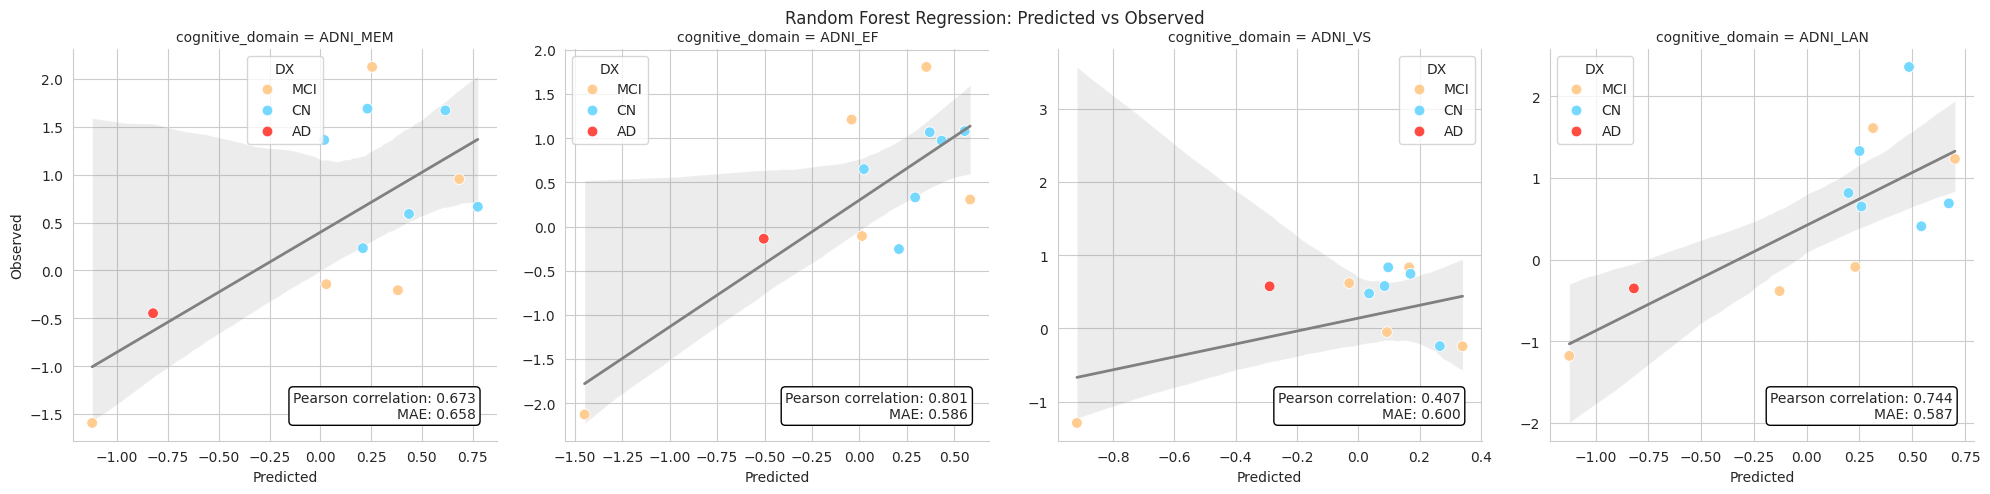

In [ ]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

sns.set_style("whitegrid")

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle("Random Forest Regression: Predicted vs Observed")  # Add a title

plt.show()


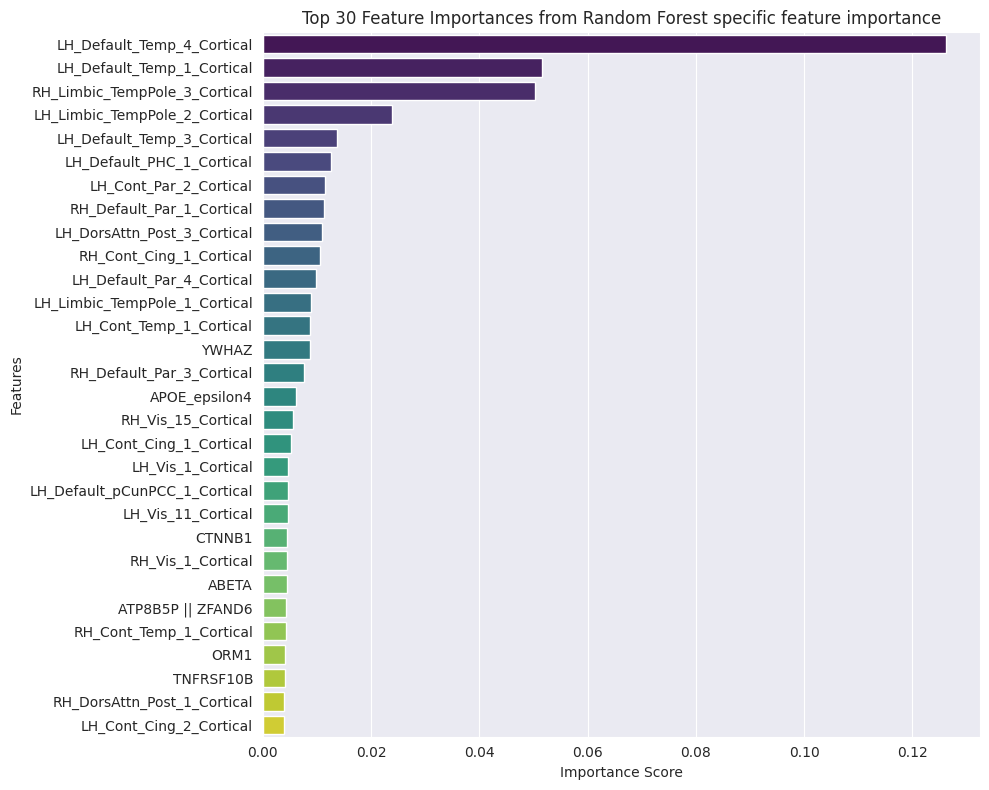

In [ ]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

n_features = 30
sns.set_style("darkgrid")

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top 20
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Plot the top 20 feature importances using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_df, x="Importance", y="Feature", palette="viridis")
plt.title(f"Top {n_features} Feature Importances from Random Forest specific feature importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

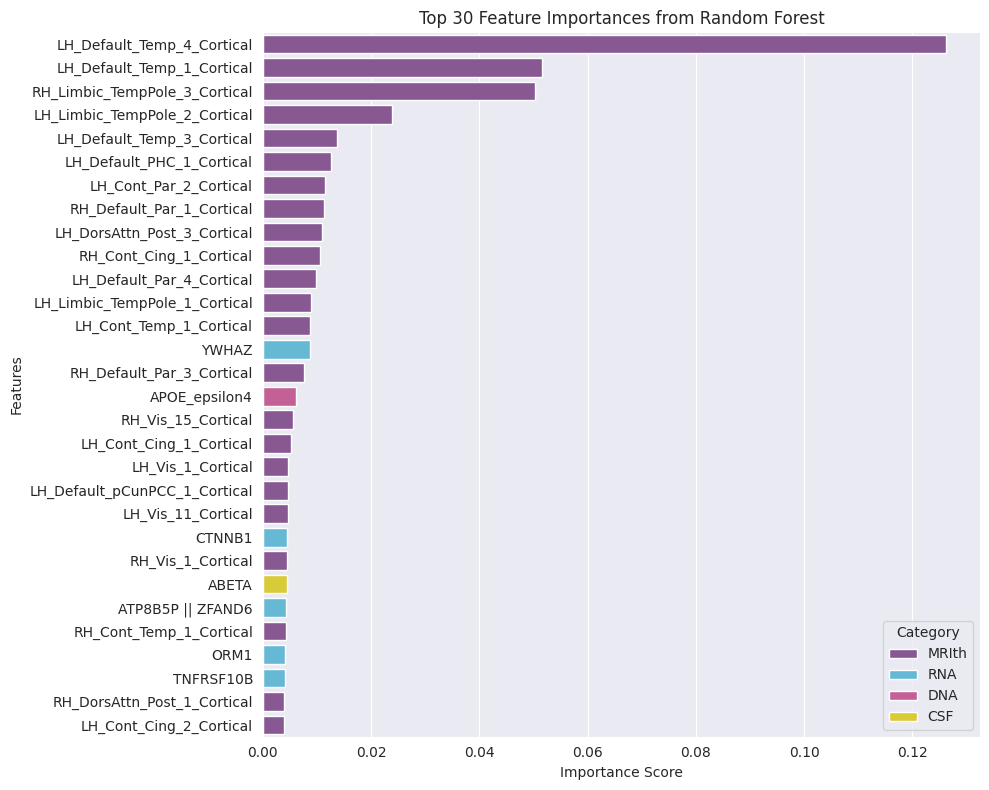

In [ ]:

category_palette = {'DNA': '#D35199',
 'RNA': '#52C2E8',
 'CSF': '#F4E01D',
 'MRIth': '#8D4F9A'}

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top N features
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Add a 'Category' column based on the 'select' dictionary
top_features_df['Category'] = top_features_df['Feature'].map(
    lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
)

# Plot the barplot with category-based coloring
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_features_df,
    x="Importance",
    y="Feature",
    hue="Category", 
    palette=category_palette
)
plt.title(f"Top {n_features} Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


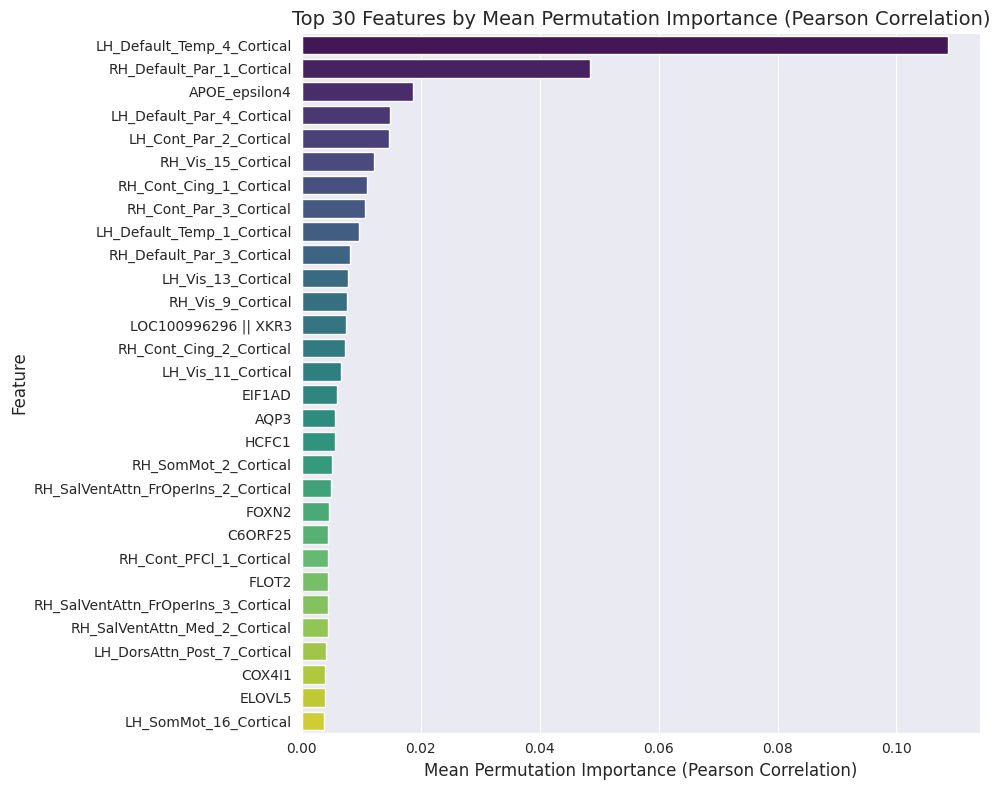

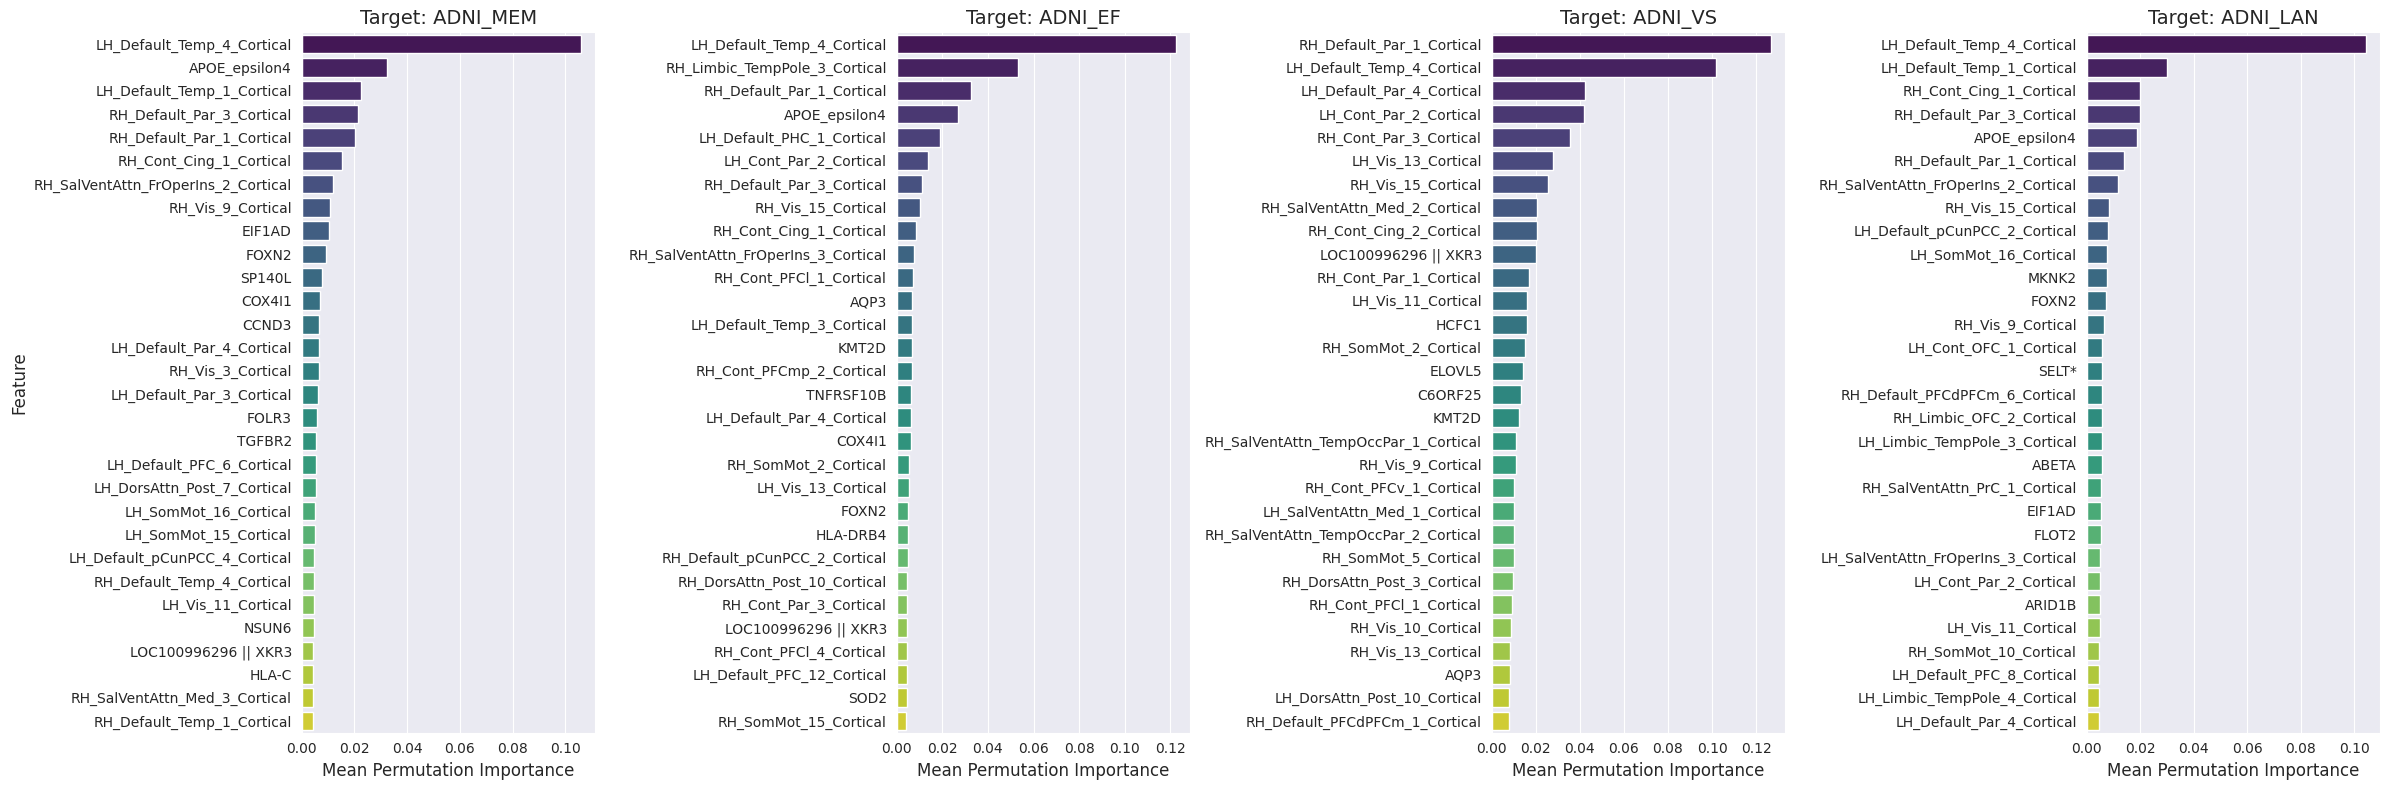

In [ ]:
X_test = X_test_adjusted
Y_test = y_test_adjusted
X_train = X_train_adjusted
Y_train = y_train_adjusted

model = rf_model

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=pearson_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)


# # Step 4: Plot for each target
# for target in permutation_results:
#     plot_importance(
#         permutation_results[target], title=f"Top 40 Features for Target: {target}"
#     )

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance (Pearson Correlation)", top_n=n_features)


# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

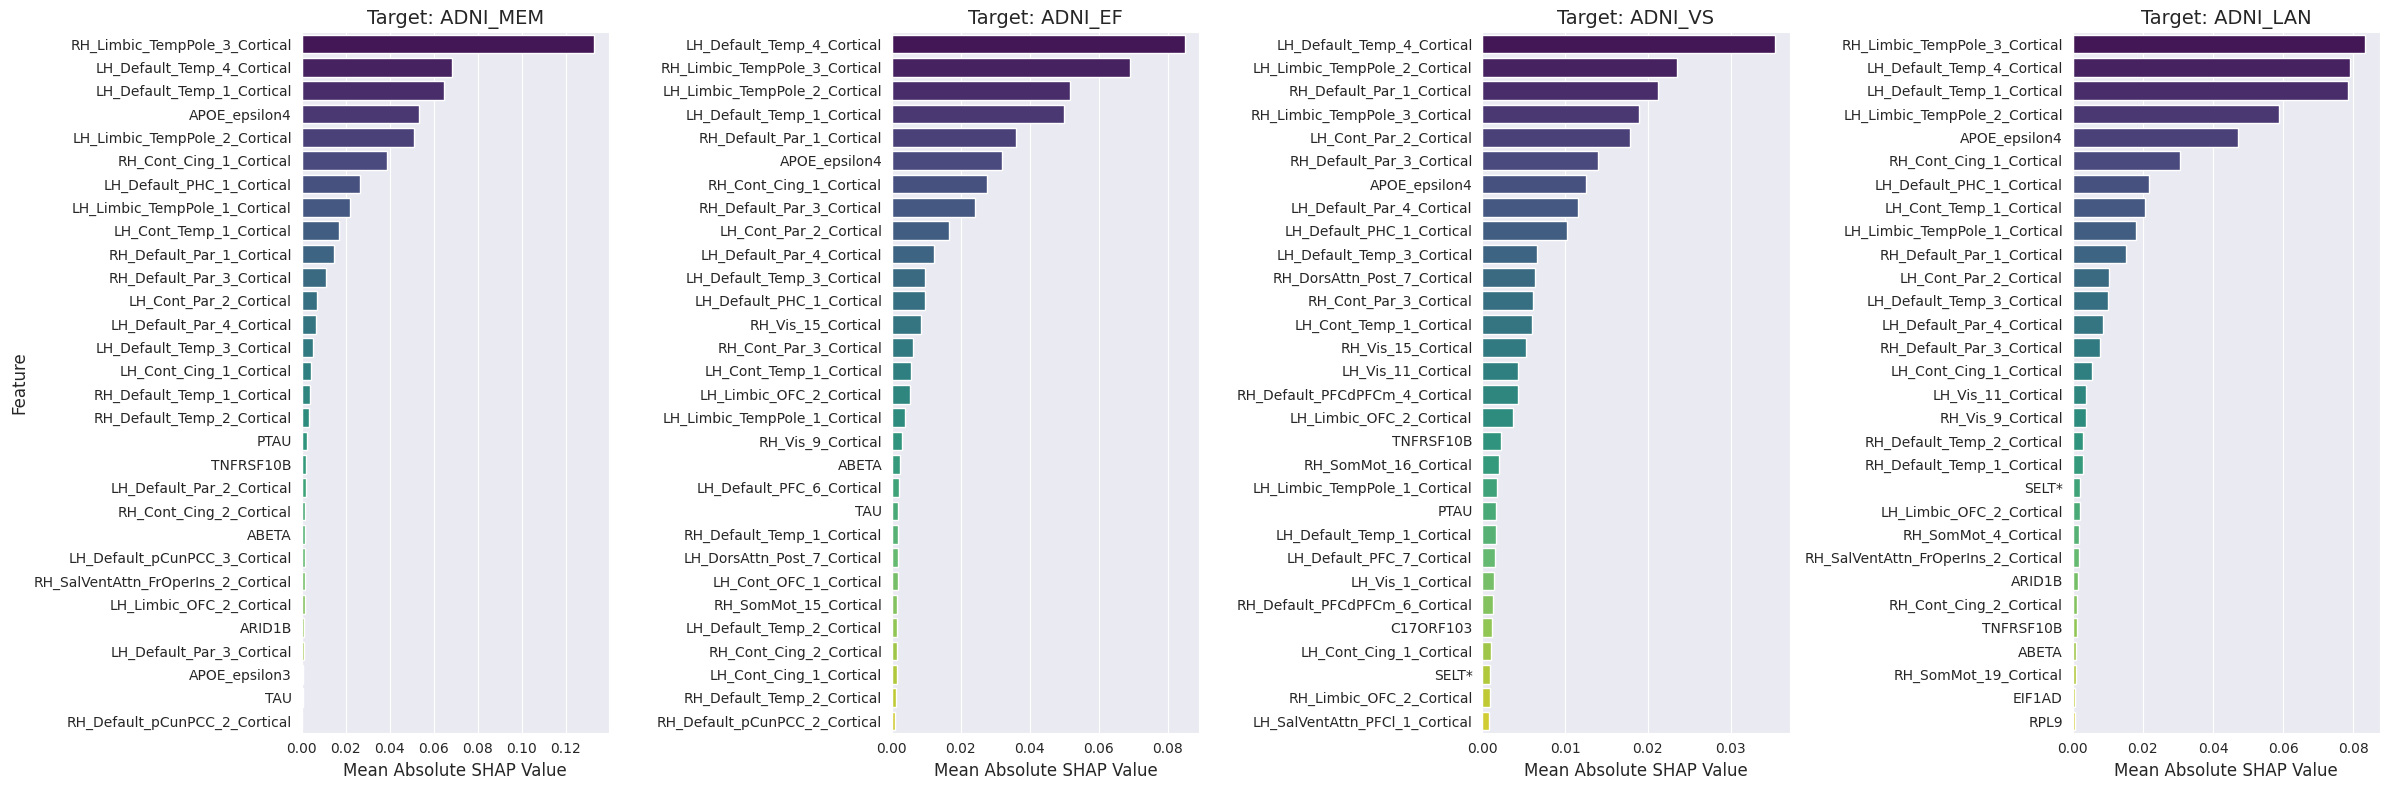

In [ ]:
# Step 1: Compute SHAP values
explainer = shap.KernelExplainer(model.predict, X_test)
shap_values = explainer(X_test)  # This computes SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

# Step 3: Plot top features for each target as subplots
num_targets = len(Y_test.columns)
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

for i, (target, ax) in enumerate(zip(shap_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = shap_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h"
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


SHAP Summary for Target: ADNI_MEM


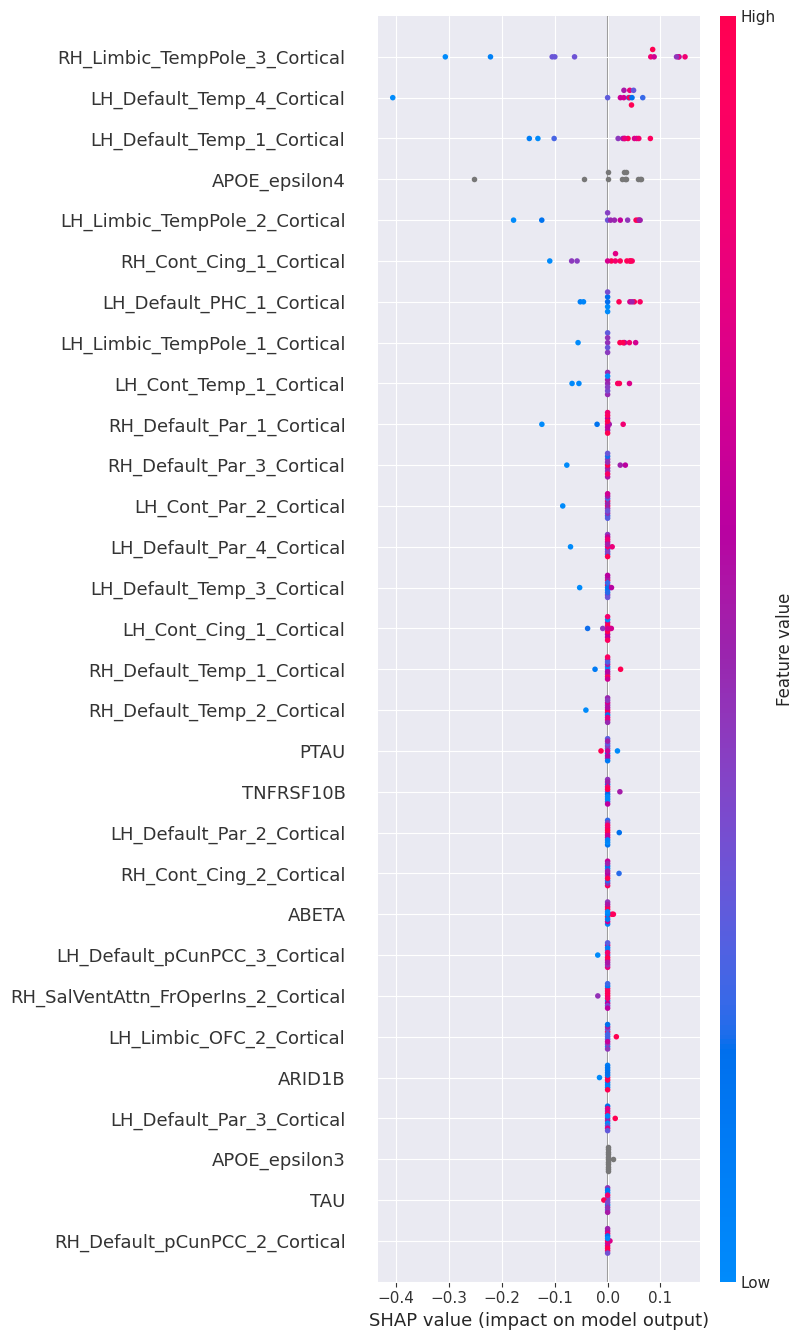

SHAP Summary for Target: ADNI_EF


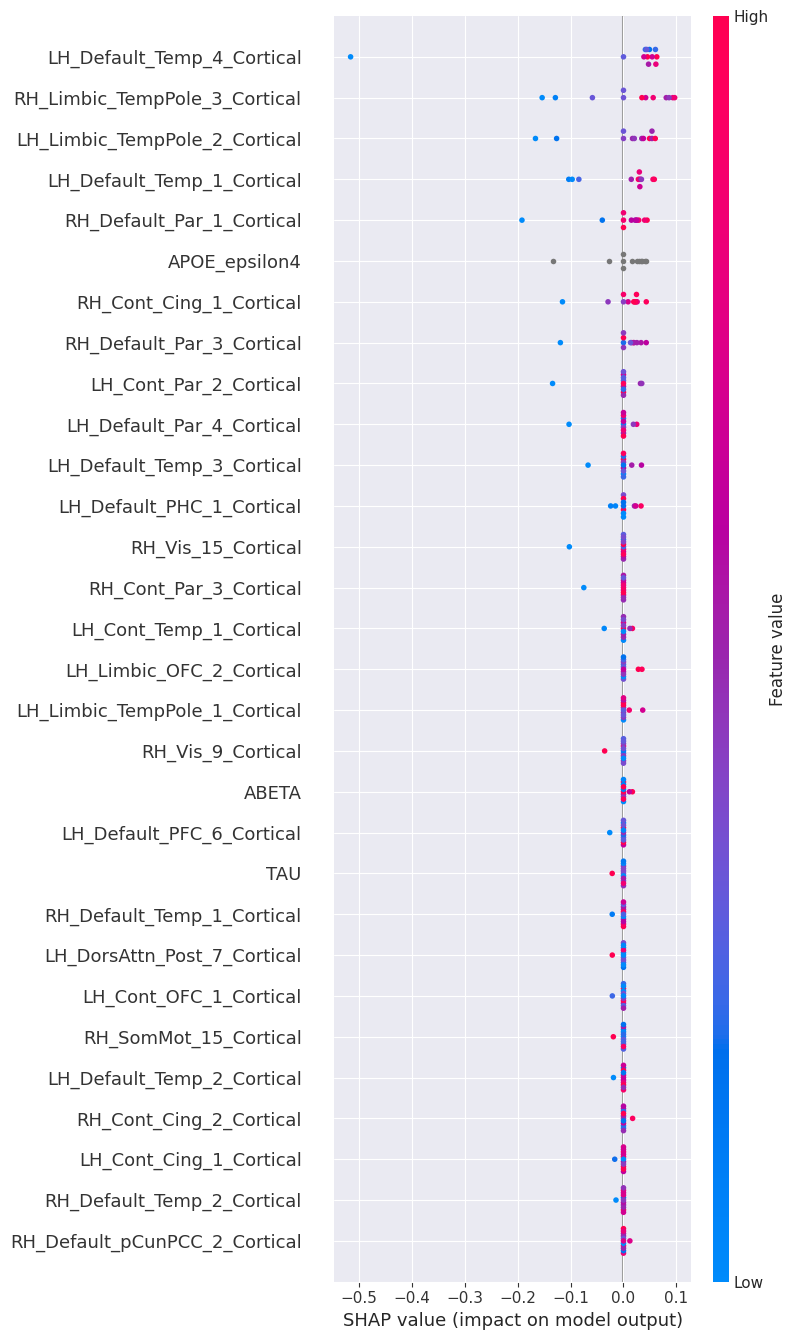

SHAP Summary for Target: ADNI_VS


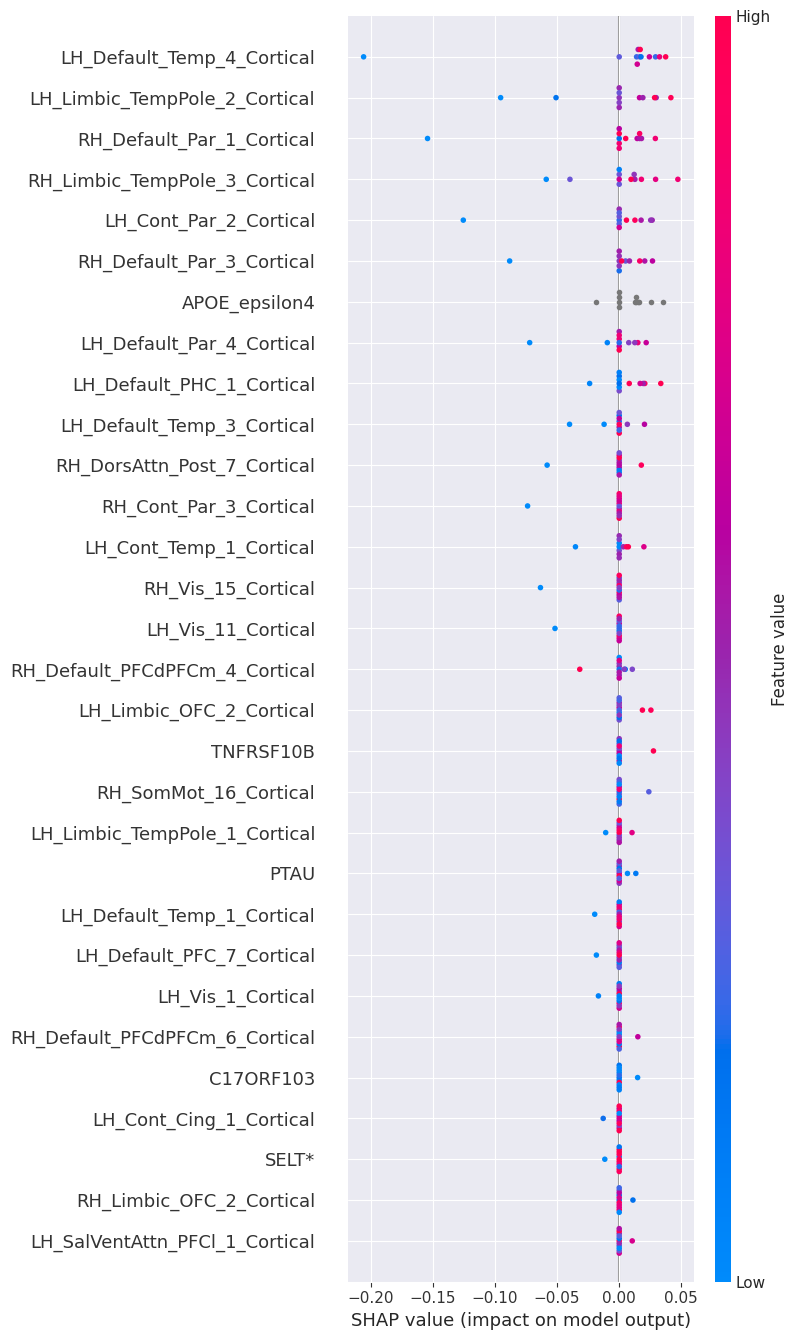

SHAP Summary for Target: ADNI_LAN


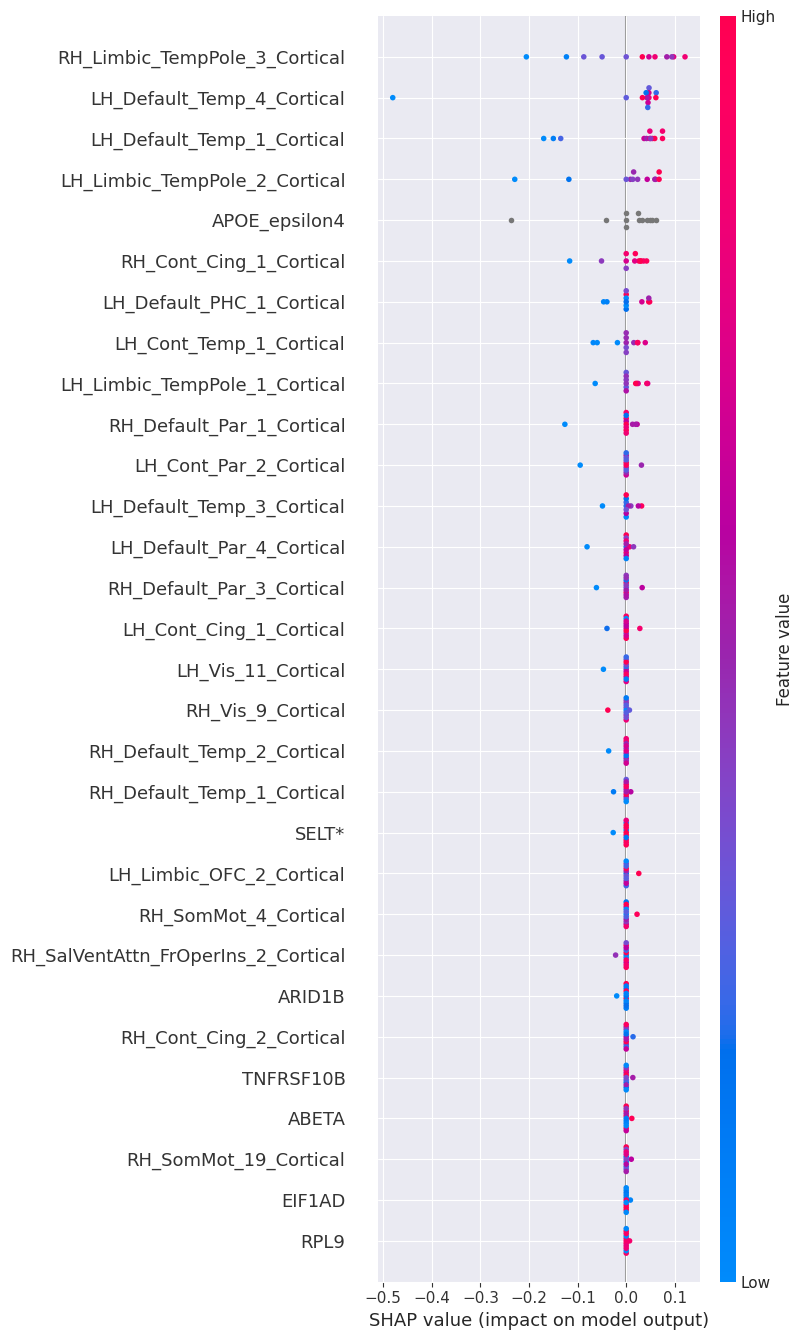

In [ ]:
# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    print(f"SHAP Summary for Target: {target}")
    shap.summary_plot(shap_values.values[:, :, i], X_test, feature_names=X_test.columns, max_display=n_features)

## Train PLS_Regressor_4_ components

In [ ]:
if True: 

    idx_train = list(df_X.isna().any(axis=1))
    idx_test = list(~df_X.isna().any(axis=1))

    set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
    intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

    for i, bool_test in enumerate(idx_test): 
        if intersect_rid_idx.iloc[i] & bool_test:
            idx_test[i] = False
            idx_train[i] = True

    df_X_train = df_X.loc[idx_train]
    df_X_test = df_X.loc[idx_test]

    df_y_train = df_y.loc[idx_train]
    df_y_test = df_y.loc[idx_test]

    c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
    c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

    continuous_model  = imputer = KNNImputer(n_neighbors=1)
    name_continuous_imputer  = "KNNImputer"
    ordinal_model = SimpleImputer(strategy="constant", fill_value=-1)
    name_ordinal_imputer = "SimpleImputer_constant"
    pls_model = PLSRegression(n_components=4)
    name_model = "PLSRegression_4_Components"

    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Separate imputers for ordinal and continuous data
    print("Using separate imputers for ordinal and continuous data.")

    df_X_train = df_X_train.copy()
    df_X_test = df_X_test.copy()

    # Continuous Imputation Transformer (Example: SimpleImputer)
    continuous_imputer = Pipeline([
        (name_continuous_imputer, continuous_model),
    ])

    # Ordinal Imputation Transformer (Example: KNN Imputer)
    ordinal_imputer = Pipeline([
        (name_ordinal_imputer, ordinal_model)
    ])

    # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_imputer, ordinal_features),
            ('continuous', continuous_imputer, continuous_features)
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

        # Separate imputers for ordinal and continuous data

    # Fit and transform, then convert back to DataFrame with original column names
    start = time.time()
    pipeline.fit(df_X_train)
    end = time.time()

    impute_model_time = end - start

    X_train_imputed = pipeline.transform(df_X_train)
    df_X_train_imputed = df_X_train.copy()
    df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

    # Transform the test set
    if df_X_test.isna().any().any(): 
        X_test_imputed = pipeline.transform(df_X_test)
        df_X_test_imputed = df_X_test.copy()
        df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
    else : 
        print("No NaN in test data -> Keep as it is. ")
        df_X_test_imputed = df_X_test

    #df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category")
    #df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category")

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()

    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

    # Perform prediction and save variables
    start = time.time()
    pls_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = pls_model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }

    def compute_all_metrics(y_test, y_pred): 
        # Metrics computed in adjusted space
        mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
        mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
        r2 = r2_score(y_test,y_pred, multioutput="raw_values")
        explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

        try: 
            corr_p = correlation(y_pred, y_test)
        except: 
            print("Problem when computing correlation!")
            if type(y_test) != type(y_pred): 
                print("Type of inputs is different.")
                corr_p = None
            else : 
                corr_p = pearsonr(y_test, y_pred)

        return mse_score, mae_score, r2, explained_variance, corr

    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }


Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
Problem when computing correlation!
Type of inputs is different.
Problem when computing correlation!
Type of inputs is different.


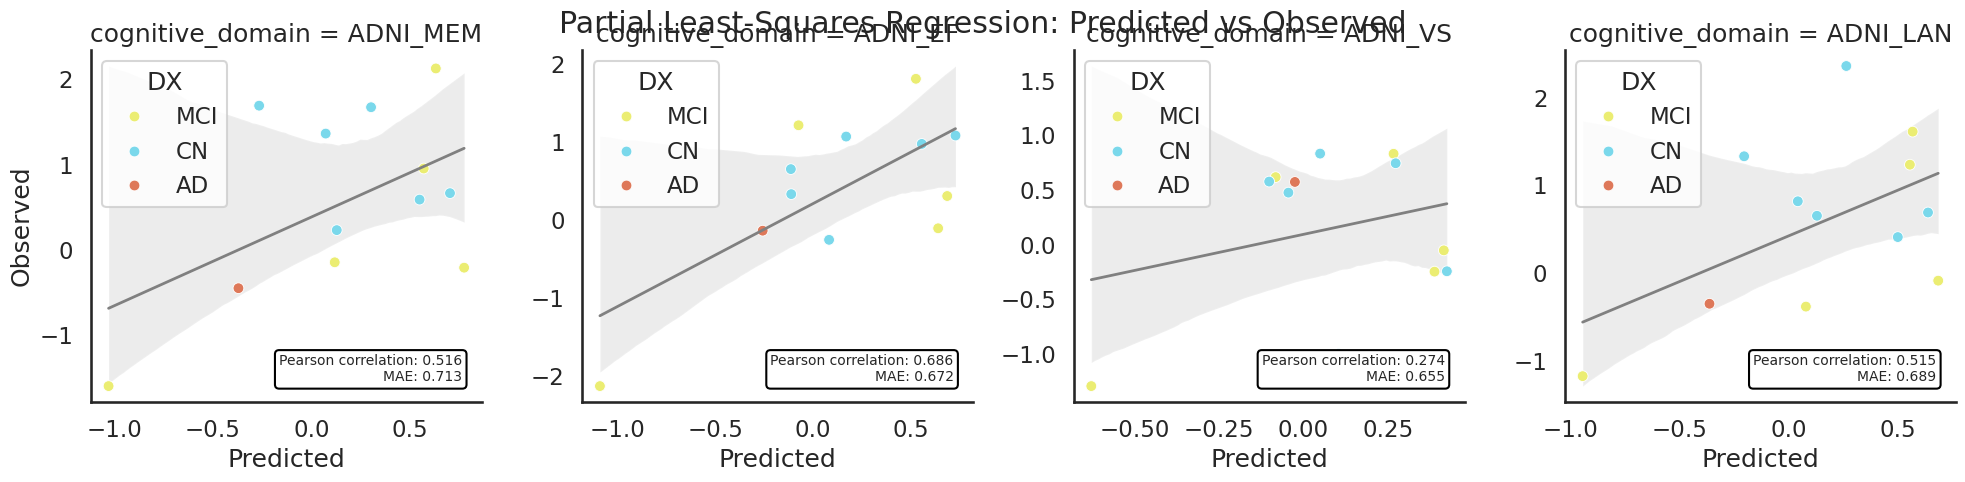

In [ ]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle("Partial Least-Squares Regression: Predicted vs Observed")  # Add a title

plt.show()


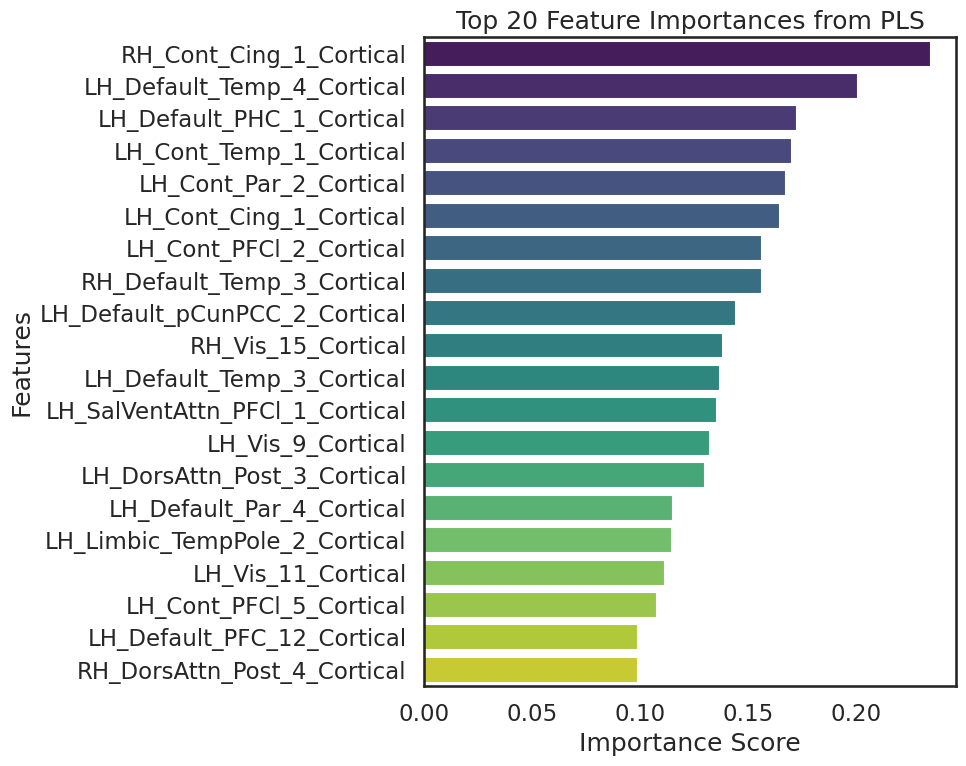

In [ ]:

# Example: Assuming your RandomForestRegressor is already trained
# rf_model = RandomForestRegressor(...)
# rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = pls_model.coef_.mean(axis=0)

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top 20
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Plot the top 20 feature importances using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_df, x="Importance", y="Feature", palette="viridis")
plt.title(f"Top {n_features} Feature Importances from PLS")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

#### Permutation importance values

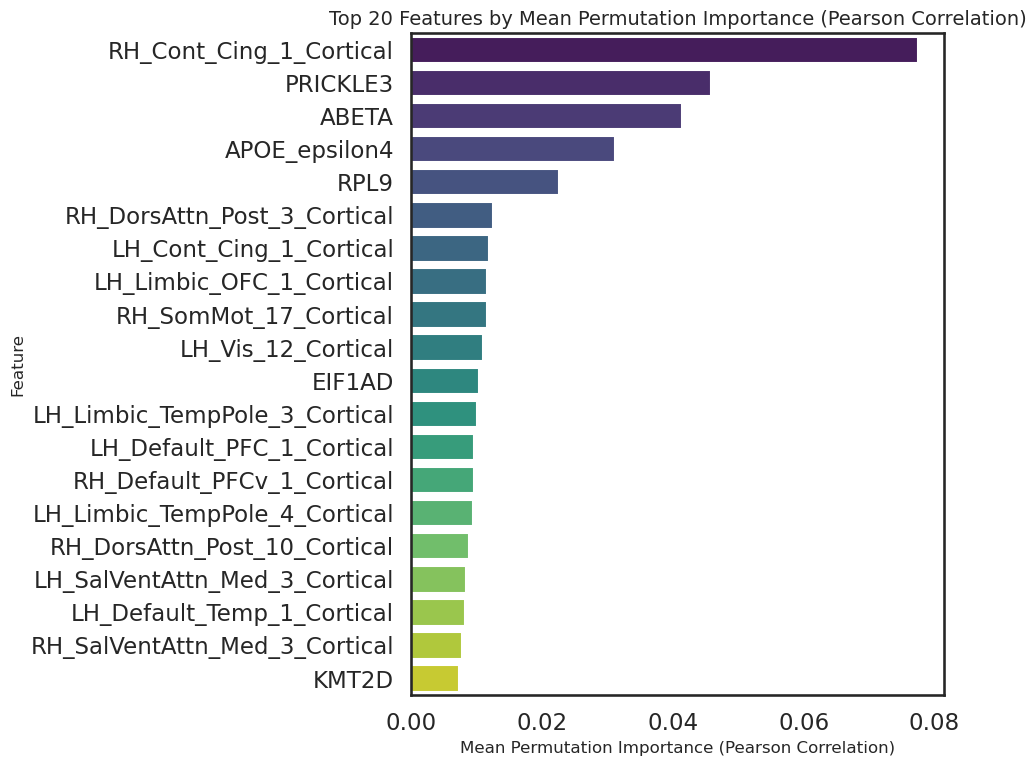

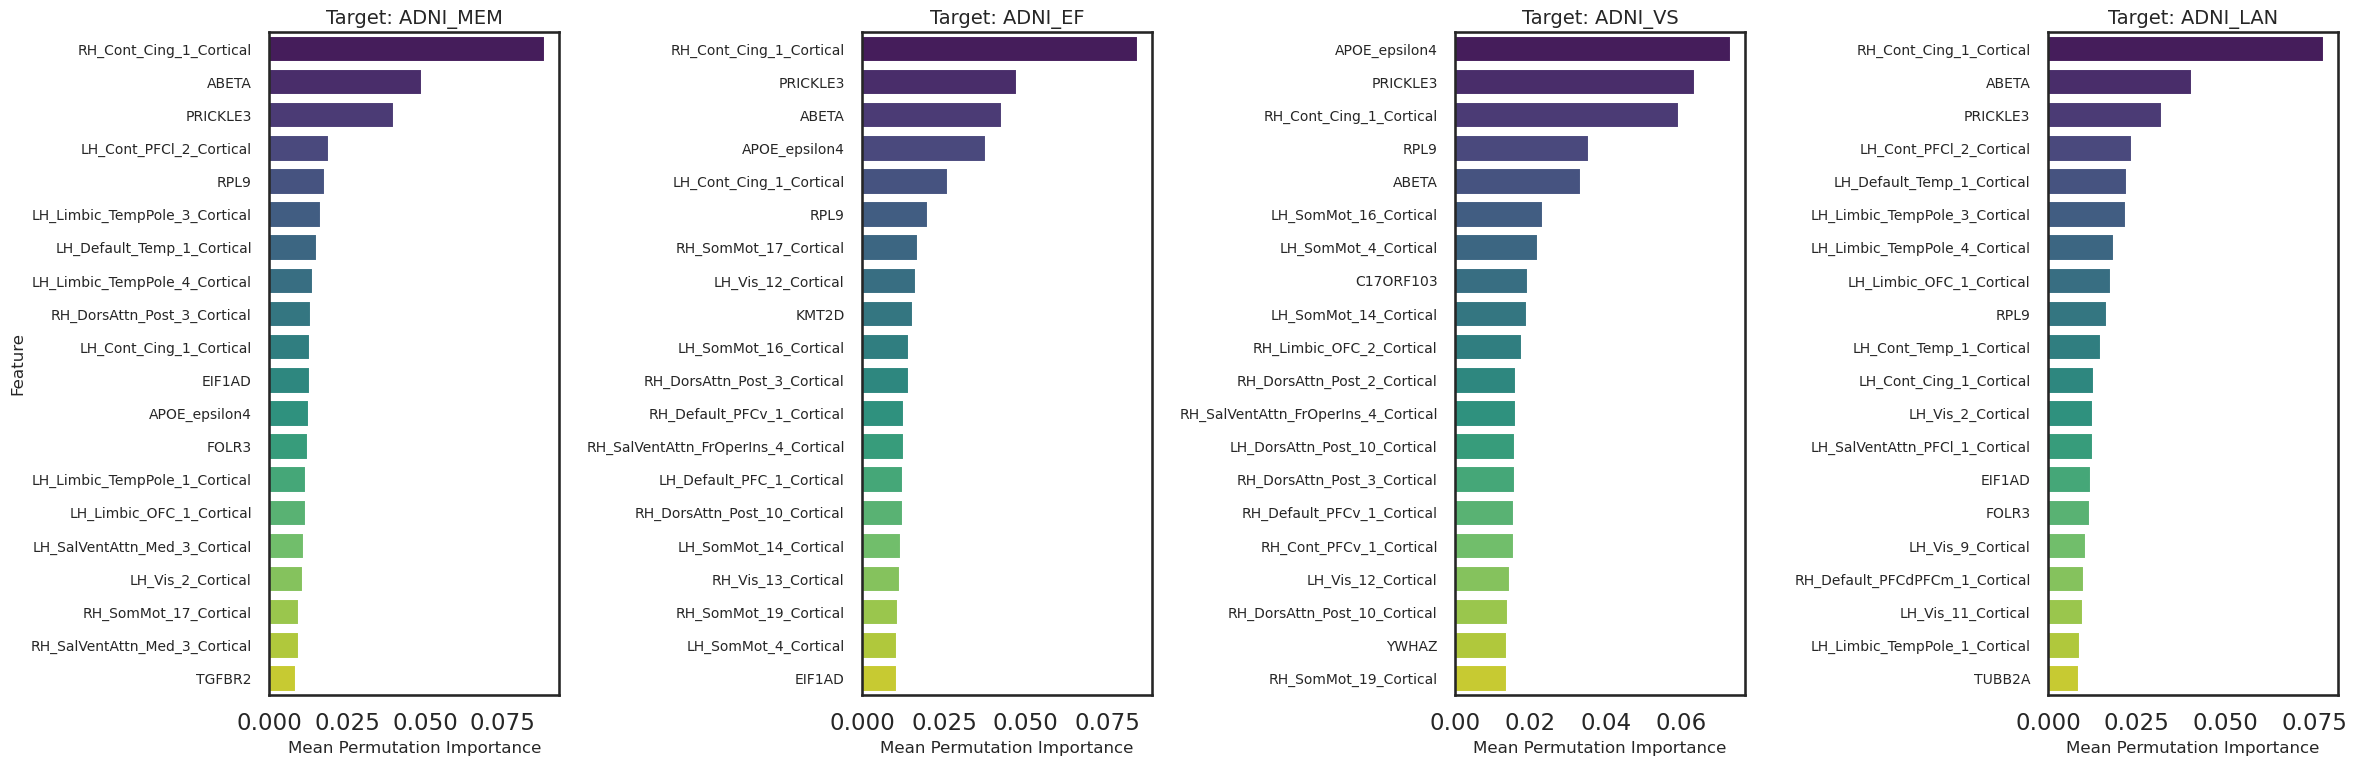

In [ ]:
X_test = X_test_adjusted
X_train = X_train_adjusted
Y_test = y_test_adjusted

model = pls_model

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=pearson_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)


# # Step 4: Plot for each target
# for target in permutation_results:
#     plot_importance(
#         permutation_results[target], title=f"Top 40 Features for Target: {target}"
#     )

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance (Pearson Correlation)", top_n=n_features)

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

#### Shapeley values

  0%|          | 0/12 [00:00<?, ?it/s]

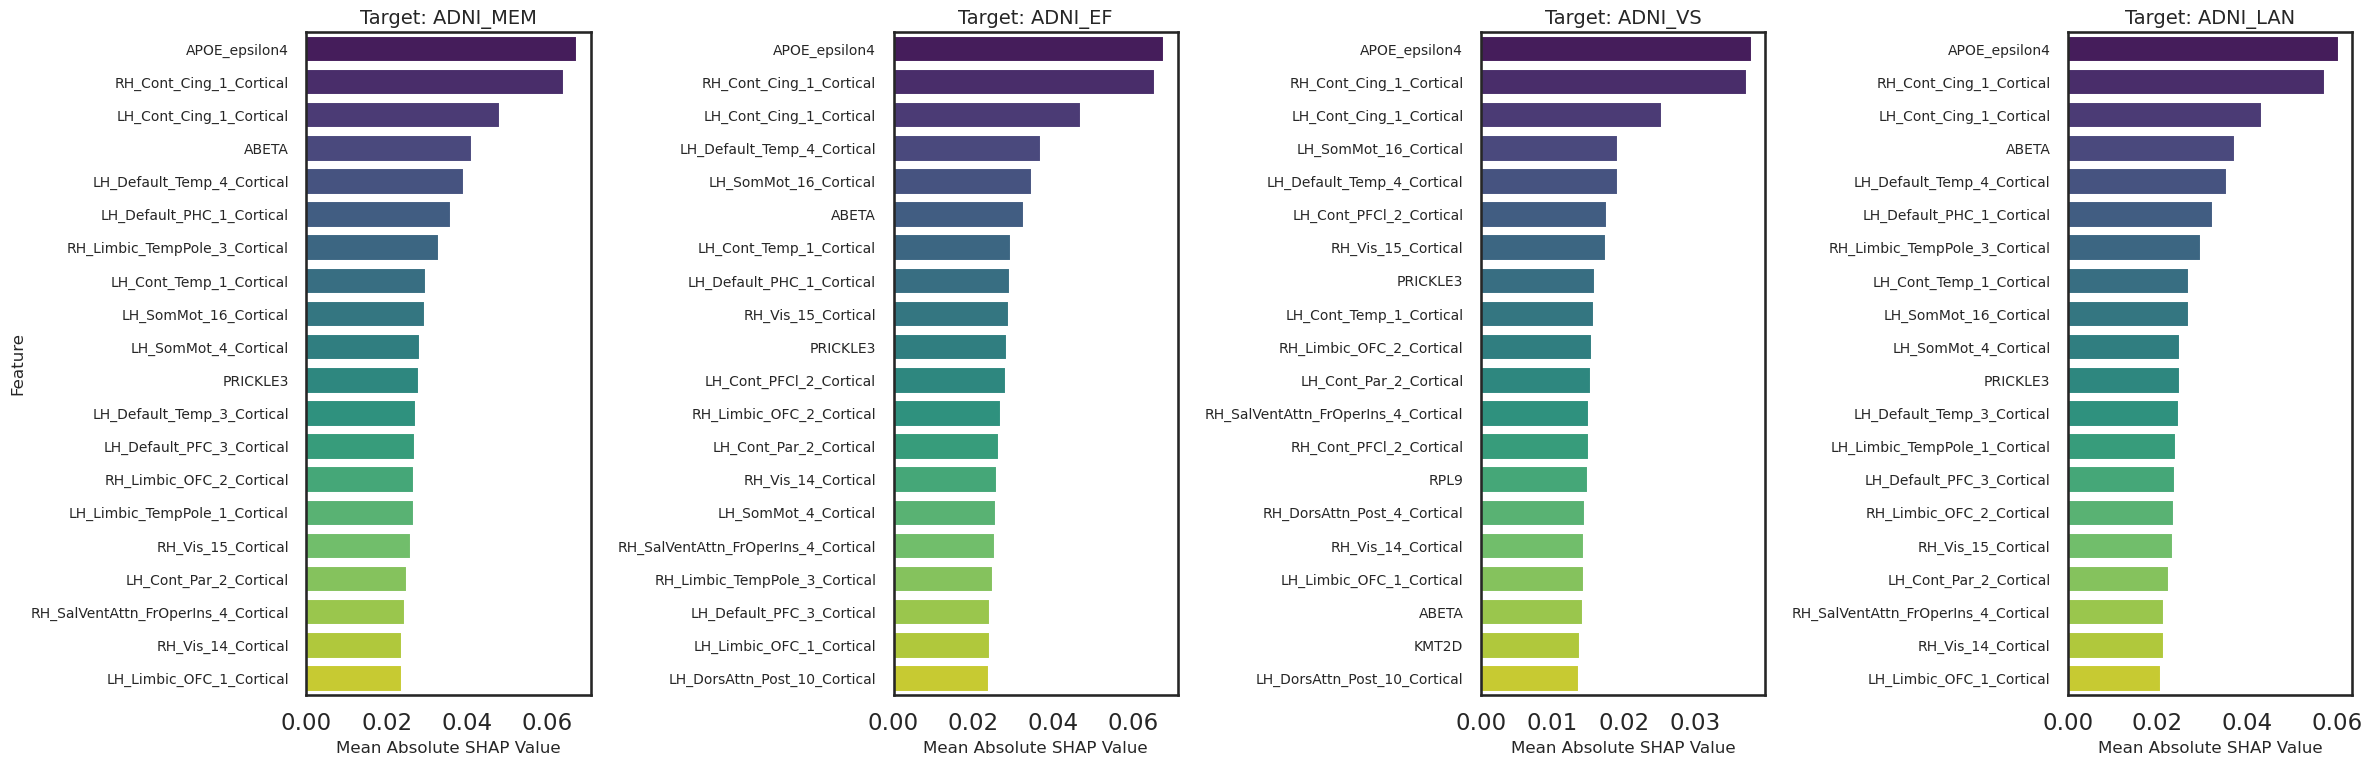

In [ ]:
# Step 1: Initialize the SHAP Explainer and Compute SHAP Values
explainer = shap.KernelExplainer(model.predict, X_test)
shap_values = explainer(X_test)  # SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

# Step 3: Plot top features for each target as subplots
num_targets = len(Y_test.columns)
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

for i, (target, ax) in enumerate(zip(shap_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = shap_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h"
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


SHAP Summary for Target: ADNI_MEM


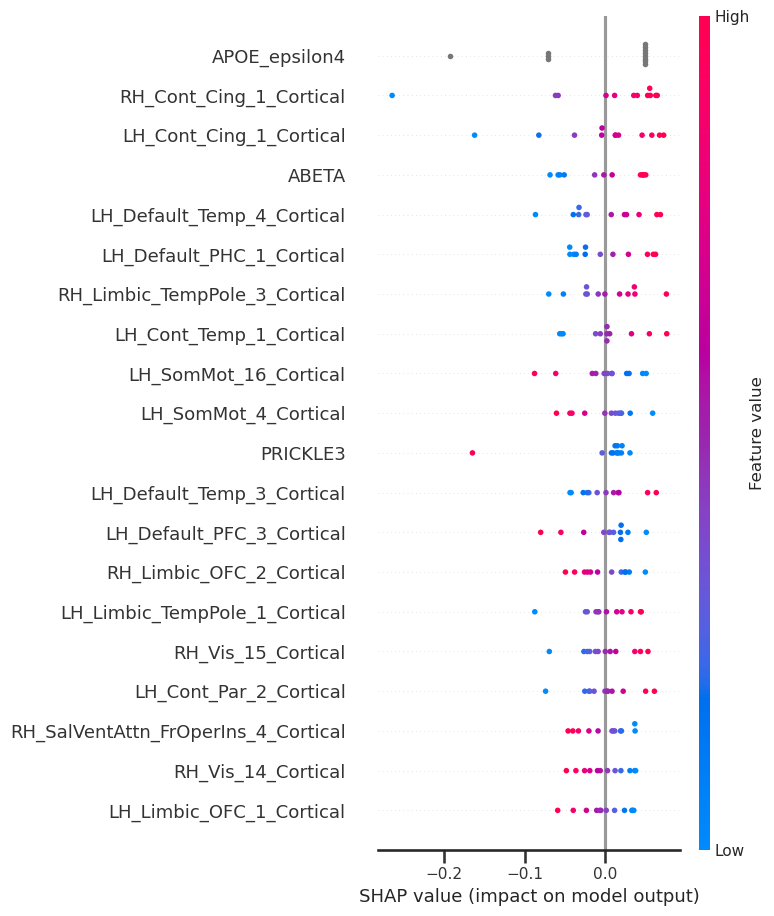

SHAP Summary for Target: ADNI_EF


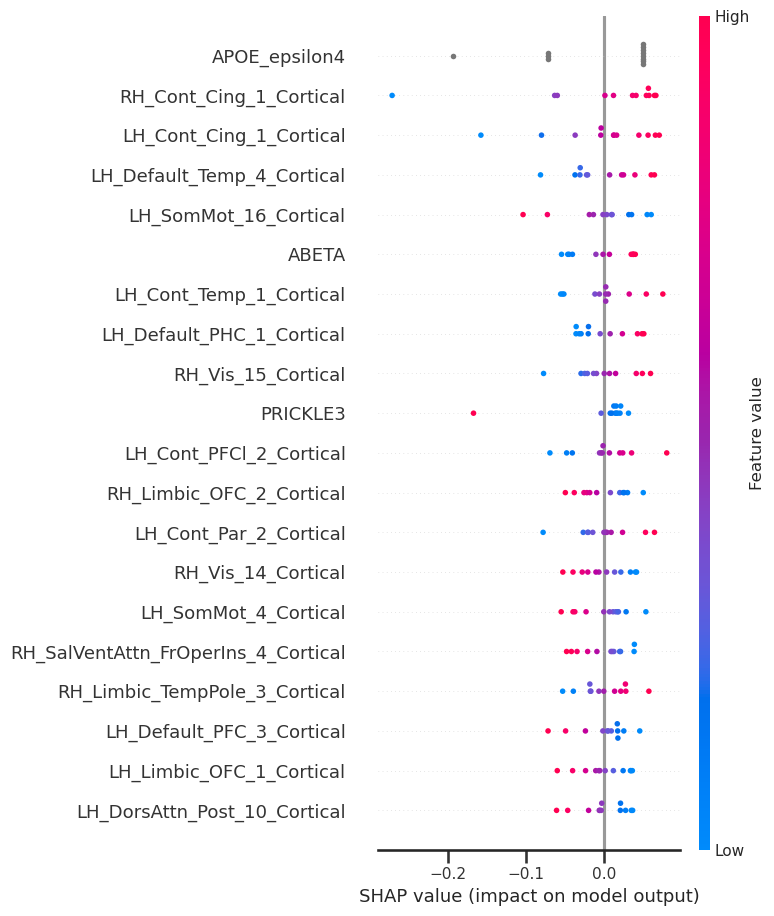

SHAP Summary for Target: ADNI_VS


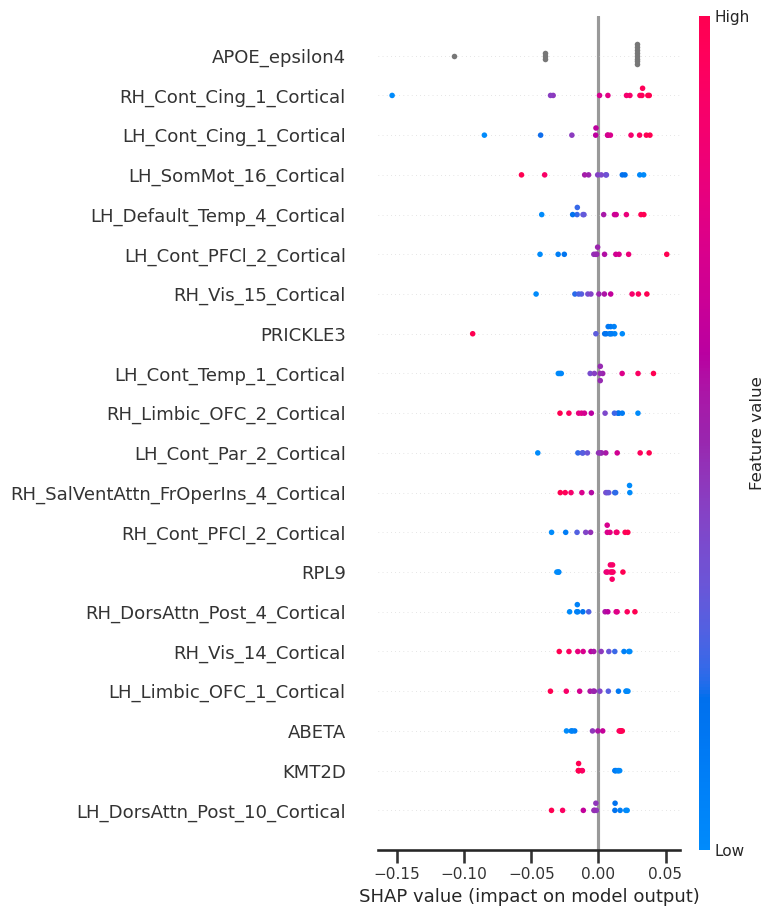

SHAP Summary for Target: ADNI_LAN


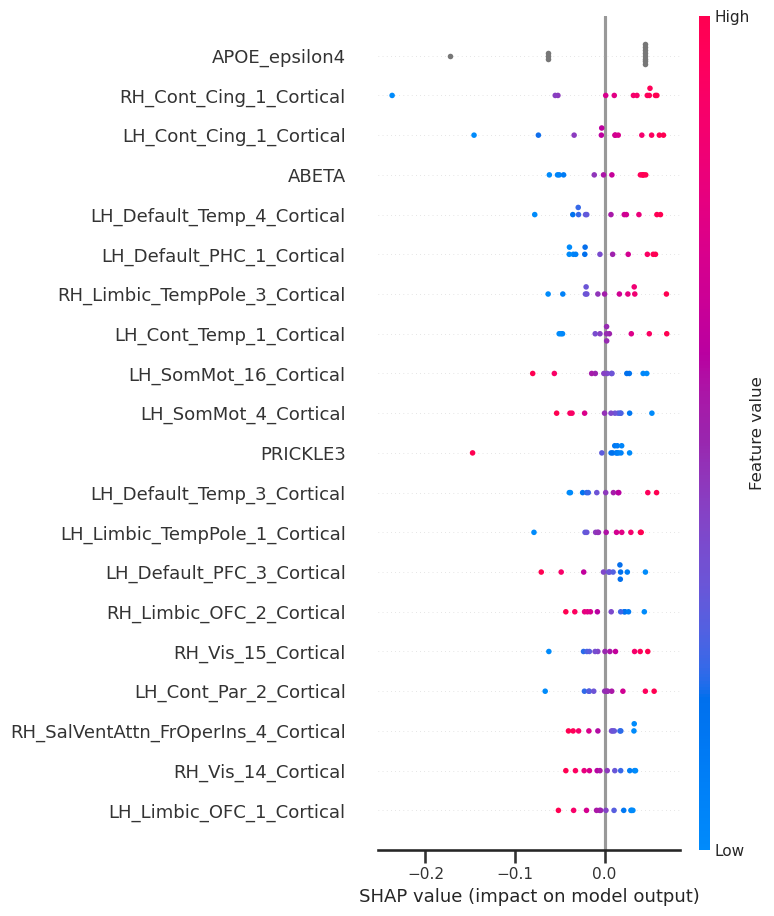

In [ ]:
# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    print(f"SHAP Summary for Target: {target}")
    shap.summary_plot(shap_values.values[:, :, i], X_test, feature_names=X_test.columns, max_display=n_features)